# Sparkify - Prediction of User Churn

In [1]:
# import libraries
from datetime import datetime
from time import time

from pyspark import SparkContext
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, col, ltrim, rtrim, regexp_replace, desc, datediff, to_date, row_number, when, count, min, max, split, udf
from pyspark.sql.types import IntegerType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, VectorAssembler, MinMaxScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# create Spark session & Spark context
spark = SparkSession.builder \
    .master('local') \
    .appName('Sparkify Model') \
    .getOrCreate()

## Load and Clean Dataset

In [3]:
df = spark.read.json('mini_sparkify_event_data.json') # mini dataset to run code on local machine
df.persist() # lazy evaluation

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Investigate Duplicate Rows

In [12]:
entire_df = df.count()
no_duplicate_df = df.dropDuplicates().count()

if entire_df > no_duplicate_df:
    raise ValueError('The dataset has duplicates')
else:
    print('The dataset has no duplicates on {} rows.'.format(entire_df)) 

The dataset has no duplicates on 286500 rows.


### Investigate Session ID & User ID

In [6]:
id_list = ['sessionId','userId']

print('The dataset has {} rows.\n'.format(df.count()))

for idx in id_list:
    # min and max values
    df.agg(min(col(idx)), max(col(idx))).show()
    # count and share of missing values
    null_count = df.where((df[idx].isNull()) | (df[idx] == '')).count()
    null_share = (null_count/df.count())*100
    print('{} rows ({}%) have missing {}.\n'.format(null_count, "{:.2f}".format(null_share), idx))

The dataset has 286500 rows.

+--------------+--------------+
|min(sessionId)|max(sessionId)|
+--------------+--------------+
|             1|          2474|
+--------------+--------------+

0 rows (0.00%) have missing sessionId.

+-----------+-----------+
|min(userId)|max(userId)|
+-----------+-----------+
|           |         99|
+-----------+-----------+

8346 rows (2.91%) have missing userId.



In [7]:
# page visits for rows with missing userId
df.select(['userId','page','ts']) \
  .where(col('userId')=='') \
  .groupby('page') \
  .count() \
  .sort(desc('count')) \
  .show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              Login| 3241|
|              About|  429|
|               Help|  272|
|           Register|   18|
|              Error|    6|
|Submit Registration|    5|
+-------------------+-----+



**Conclusion:** Since the events with missing user IDs seem to be attributed to users that are not logged in (most of these events are located at pages "Home" & "Login"), these events will be excluded from further analyses.

In [4]:
# drop rows with missing userId
df_clean = df.filter(df['userId'] != '')
print('The clean dataset is reduced to {} rows.\n'.format(df_clean.count()))

The clean dataset is reduced to 278154 rows.



### Investigate Length

In [5]:
# filter for pages with length = None
no_length_pages = df_clean.filter(df_clean.length.isNull()) \
                          .select(col('page') \
                          .alias('no_length_pages')) \
                          .dropDuplicates()

# get a list of possible pages that could be visited
all_pages = df_clean.select('page').dropDuplicates()

print('These pages are connected to empty length values:')
for row in list(no_length_pages.sort('page').collect()):
    print(row[0])

# find values in all_pages that are not in no_length_pages
# these are the pages that are always connected to a length value
for row in set(all_pages.collect()) - set(no_length_pages.collect()):
    print('\nThese pages always have the column length filled:\n' + row.page)

These pages are connected to empty length values:
About
Add Friend
Add to Playlist
Cancel
Cancellation Confirmation
Downgrade
Error
Help
Home
Logout
Roll Advert
Save Settings
Settings
Submit Downgrade
Submit Upgrade
Thumbs Down
Thumbs Up
Upgrade

These pages always have the column length filled:
NextSong


**Conclusion:** Data seems to be valid since the empty length values are always connected to pages that are **not** playing songs. No cleaning necessary.

### Convert Timestamp to Datetime & Date

In [6]:
# user defined function to convert timestamp to datetime
datetime_converter = udf(lambda x: datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

# create new column 'datetime' by applying datetime_converter to column 'ts'
df_clean = df_clean.withColumn('datetime', datetime_converter(df_clean['ts']))
df_clean = df_clean.withColumn('registration_datetime', datetime_converter(df_clean['registration']))

# create new column 'date' by splitting the column 'datetime' by space
df_clean = df_clean.withColumn('date', split('datetime',' ')[0])
df_clean = df_clean.withColumn('registration_date', split('registration_datetime',' ')[0])

df_clean.select('ts','datetime','date', 'registration', 'registration_datetime', 'registration_date').show(5)

+-------------+-------------------+----------+-------------+---------------------+-----------------+
|           ts|           datetime|      date| registration|registration_datetime|registration_date|
+-------------+-------------------+----------+-------------+---------------------+-----------------+
|1538352117000|2018-10-01 00:01:57|2018-10-01|1538173362000|  2018-09-28 22:22:42|       2018-09-28|
|1538352180000|2018-10-01 00:03:00|2018-10-01|1538331630000|  2018-09-30 18:20:30|       2018-09-30|
|1538352394000|2018-10-01 00:06:34|2018-10-01|1538173362000|  2018-09-28 22:22:42|       2018-09-28|
|1538352416000|2018-10-01 00:06:56|2018-10-01|1538331630000|  2018-09-30 18:20:30|       2018-09-30|
|1538352676000|2018-10-01 00:11:16|2018-10-01|1538173362000|  2018-09-28 22:22:42|       2018-09-28|
+-------------+-------------------+----------+-------------+---------------------+-----------------+
only showing top 5 rows



### Extract Weekday from Timestamp

In [7]:
# user defined function to extract weekday from timestamp
weekday_converter = udf(lambda x: datetime.weekday(datetime.strptime(datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"), '%Y-%m-%d %H:%M:%S')))

# create new column 'weekday' by applying weekday_converter to column 'ts'
df_clean = df_clean.withColumn('weekday', weekday_converter(df_clean['ts']))
df_clean = df_clean.withColumn('registration_weekday', weekday_converter(df_clean['registration']))

df_clean.select('ts','date','weekday', 'registration', 'registration_date','registration_weekday').show(5)

+-------------+----------+-------+-------------+-----------------+--------------------+
|           ts|      date|weekday| registration|registration_date|registration_weekday|
+-------------+----------+-------+-------------+-----------------+--------------------+
|1538352117000|2018-10-01|      0|1538173362000|       2018-09-28|                   4|
|1538352180000|2018-10-01|      0|1538331630000|       2018-09-30|                   6|
|1538352394000|2018-10-01|      0|1538173362000|       2018-09-28|                   4|
|1538352416000|2018-10-01|      0|1538331630000|       2018-09-30|                   6|
|1538352676000|2018-10-01|      0|1538173362000|       2018-09-28|                   4|
+-------------+----------+-------+-------------+-----------------+--------------------+
only showing top 5 rows



### Extract Year, Month & Day from Date

In [8]:
# create new columns 'year', 'month' & 'day' by splitting the column 'date' by hyphen
df_clean = df_clean.withColumn('year', split('date','-')[0])
df_clean = df_clean.withColumn('month', split('date','-')[1])
df_clean = df_clean.withColumn('day', split('date','-')[2])
df_clean = df_clean.withColumn('registration_year', split('registration_date','-')[0])
df_clean = df_clean.withColumn('registration_month', split('registration_date','-')[1])
df_clean = df_clean.withColumn('registration_day', split('registration_date','-')[2])

df_clean.select('datetime','year','month','day','registration_datetime','registration_year','registration_month','registration_day').show(5)

+-------------------+----+-----+---+---------------------+-----------------+------------------+----------------+
|           datetime|year|month|day|registration_datetime|registration_year|registration_month|registration_day|
+-------------------+----+-----+---+---------------------+-----------------+------------------+----------------+
|2018-10-01 00:01:57|2018|   10| 01|  2018-09-28 22:22:42|             2018|                09|              28|
|2018-10-01 00:03:00|2018|   10| 01|  2018-09-30 18:20:30|             2018|                09|              30|
|2018-10-01 00:06:34|2018|   10| 01|  2018-09-28 22:22:42|             2018|                09|              28|
|2018-10-01 00:06:56|2018|   10| 01|  2018-09-30 18:20:30|             2018|                09|              30|
|2018-10-01 00:11:16|2018|   10| 01|  2018-09-28 22:22:42|             2018|                09|              28|
+-------------------+----+-----+---+---------------------+-----------------+------------------+-

### Extract Hour from Datetime

In [9]:
# user defined function to integer-convert a value
convert_to_integer = udf(lambda x : int(x), IntegerType())

# create new column 'hour' by splitting the column datetime by space & colon and applying convert_to_integer
df_clean = df_clean.withColumn('hour', split(split('datetime',' ')[1],':')[0])
df_clean = df_clean.withColumn('hour', convert_to_integer(df_clean['hour']))
df_clean = df_clean.withColumn('registration_hour', split(split('registration_datetime',' ')[1],':')[0])
df_clean = df_clean.withColumn('registration_hour', convert_to_integer(df_clean['registration_hour']))

df_clean.select('datetime','hour', 'registration_datetime','registration_hour').show(5)

+-------------------+----+---------------------+-----------------+
|           datetime|hour|registration_datetime|registration_hour|
+-------------------+----+---------------------+-----------------+
|2018-10-01 00:01:57|   0|  2018-09-28 22:22:42|               22|
|2018-10-01 00:03:00|   0|  2018-09-30 18:20:30|               18|
|2018-10-01 00:06:34|   0|  2018-09-28 22:22:42|               22|
|2018-10-01 00:06:56|   0|  2018-09-30 18:20:30|               18|
|2018-10-01 00:11:16|   0|  2018-09-28 22:22:42|               22|
+-------------------+----+---------------------+-----------------+
only showing top 5 rows



### Extract Day Half from Hour

In [10]:
# user defined function to split the day in two halves
split_half_day = udf(lambda x : 1 if x < 12 else 2)

# create new column 'day_half' by applying split_half_day
df_clean = df_clean.withColumn('day_half', split_half_day(df_clean['hour']))

df_clean.select('hour','day_half').dropDuplicates().sort('hour').show(25)

+----+--------+
|hour|day_half|
+----+--------+
|   0|       1|
|   1|       1|
|   2|       1|
|   3|       1|
|   4|       1|
|   5|       1|
|   6|       1|
|   7|       1|
|   8|       1|
|   9|       1|
|  10|       1|
|  11|       1|
|  12|       2|
|  13|       2|
|  14|       2|
|  15|       2|
|  16|       2|
|  17|       2|
|  18|       2|
|  19|       2|
|  20|       2|
|  21|       2|
|  22|       2|
|  23|       2|
+----+--------+



### Extract Days Since Registration from Date & Registration Date

In [11]:
# create new column 'days_since_registration' by  calculating the date difference between 'date' & 'registration_date'
df_clean = df_clean.withColumn('days_since_registration', datediff(to_date(df_clean['date']), to_date(df_clean['registration_date'])))

df_clean.select('registration_date', 'date', 'days_since_registration').show(5)

+-----------------+----------+-----------------------+
|registration_date|      date|days_since_registration|
+-----------------+----------+-----------------------+
|       2018-09-28|2018-10-01|                      3|
|       2018-09-30|2018-10-01|                      1|
|       2018-09-28|2018-10-01|                      3|
|       2018-09-30|2018-10-01|                      1|
|       2018-09-28|2018-10-01|                      3|
+-----------------+----------+-----------------------+
only showing top 5 rows



### Extract Browser & Device/Operating System from User Agent

In [12]:
# user defined function to find browser
find_browser = udf(lambda x : 'Internet Explorer' if 'Trident' in x else 
                   ('Chrome' if 'Chrome' in x else 
                    ('Safari' if 'Safari' in x else 
                     ('Firefox' if 'Firefox' in x else np.NaN))))

# modify column 'device_os' by re-mapping the column
df_clean = df_clean.withColumn('browser', find_browser(df_clean['userAgent']))

df_clean.groupby('browser').count().show()

+-----------------+------+
|          browser| count|
+-----------------+------+
|Internet Explorer| 15347|
|          Firefox| 55646|
|           Safari| 61570|
|           Chrome|145591|
+-----------------+------+



In [13]:
# create new column 'device_os' by splitting column userAgent by bracket and space
df_clean = df_clean.withColumn('device_os', regexp_replace(split(split('userAgent','\(')[1],' ')[0],';',''))
df_clean.groupby('device_os').count().show()
df_clean.filter(col('device_os')=='compatible').select('userAgent','device_os').dropDuplicates().collect()

+----------+------+
| device_os| count|
+----------+------+
|      iPad| 11381|
|       X11|  8961|
|    iPhone| 11192|
| Macintosh|102749|
|compatible| 10684|
|   Windows|133187|
+----------+------+



[Row(userAgent='Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)', device_os='compatible'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0)', device_os='compatible'),
 Row(userAgent='Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)', device_os='compatible')]

In [14]:
# user defined function to map 'compatible' to 'Windows'
map_compatible = udf(lambda x : 'Windows' if x == 'compatible' else x)

# modify column 'device_os' by re-mapping the column
df_clean = df_clean.withColumn('device_os', map_compatible(df_clean['device_os']))

df_clean.groupby('device_os').count().show()

+---------+------+
|device_os| count|
+---------+------+
|     iPad| 11381|
|      X11|  8961|
|   iPhone| 11192|
|Macintosh|102749|
|  Windows|143871|
+---------+------+



### Extract State from Location

In [15]:
# create new column 'state' by splitting the column 'location' by comma
df_clean = df_clean.withColumn('state', ltrim(rtrim(split('location',',')[1])))

df_clean.select('location','state').show(5)

+--------------------+-----+
|            location|state|
+--------------------+-----+
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
|Boston-Cambridge-...|MA-NH|
|     Bakersfield, CA|   CA|
+--------------------+-----+
only showing top 5 rows



## Exploratory Data Analysis

In [44]:
# prepare functions for exploratory data analysis

colors = ['paleturquoise', 'lightseagreen','darkturquoise','darkcyan']

cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]


def show_descriptives(df, col):
    '''
    '''
    df.select(col).describe().show()
    
    
def plot_histogram(df, col, size=(8,8)):
    '''
    '''
    # figure settings
    fig, ax = plt.subplots(figsize=size)
    
    ax = sns.histplot(df.toPandas()[col], ax=ax, kde=True, color=colors[0])
    ax.set(xlabel=col.replace('_',' ').title(), ylabel='Count')
    
    plt.show()
    
    
def plot_histogram_grouped(df, col, group, n, size=(8,8)):
    '''
    '''
    # figure settings
    fig, ax = plt.subplots(figsize=size)
    
    ax = sns.histplot(x=df.toPandas()[col], hue=df.toPandas()[group], ax=ax, kde=True, palette=colors[:n])
    ax.set(xlabel=col.replace('_',' ').title(), ylabel='Count')
    
    plt.show()
    
    
def plot_bar_chart(df, x_col, y_col, size=(8,8), color=colors):
    '''
    '''
    # wrangle data
    df_sorted = df.toPandas().sort_values([x_col], ascending=False).reset_index(drop=True)
    x = df_sorted[x_col]
    y = df_sorted[y_col]
    
    # figure settings
    fig = plt.subplots(figsize=size)

    ax = sns.barplot(x=x, y=y, palette=color)
    ax.set(xlabel=x_col.replace('_',' ').title(),
           ylabel=y_col.replace('_',' ').title())
    
    plt.show()    
    
    
def plot_bar_chart_grouped(df, x_col, y_col, group, subplots=2, dodge=True, sharey=True, size=(16,8), x_lim=0, y_lim=250000):
    '''
    '''
    # wrangle data
    
    # create dictionary for sorting order
    sort_list = df.groupby(y_col).sum(x_col).sort(desc('sum({})'.format(x_col))).toPandas()[y_col].tolist()
    sort_dict = dict(zip(sort_list, range(len(sort_list))))

    # create a new column 'rank' for sorting purposes
    def working_fun(mapping):
        def f(x):
            return mapping.get(x)
        return udf(f)

    df = df.withColumn('rank', working_fun(sort_dict)(col(y_col)))
    
    # user defined function to integer-convert a value
    convert_to_integer = udf(lambda x : int(x), IntegerType())

    # modify column 'rank' by applying convert_to_integer
    df = df.withColumn('rank', convert_to_integer(df['rank']))

    df_sorted = df.toPandas().sort_values('rank').reset_index(drop=True)
    x = df_sorted[x_col]
    y = df_sorted[y_col]
    
    if subplots == 2:
        # figure settings
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=size, sharey=sharey)

        # first subplot
        ax1 = sns.barplot(x=x, y=y, ax=ax1, hue=df_sorted[group],dodge=dodge, palette=colors)
        ax1.set(xlabel=x_col.replace('_',' ').title(),
                    ylabel=y_col.replace('_',' ').title())
        ax1.legend(title=group.replace('_',' ').title())

        # second subplot
        ax2 = sns.barplot(x=x, y=y, ax=ax2, hue=df_sorted[group], dodge=dodge, palette=colors)
        ax2.set(xlabel=x_col.replace('_',' ').title(),
                    ylabel=y_col.replace('_',' ').title(),
                    xlim=(x_lim, y_lim))
        ax2.legend(title=group.replace('_',' ').title())
        
    else:
        # figure settings
        fig, ax = plt.subplots(figsize=size)

        # first subplot
        ax = sns.barplot(x=x, y=y, ax=ax, hue=df_sorted[group],dodge=dodge, palette=colors)
        ax.set(xlabel=x_col.replace('_',' ').title(),
                    ylabel=y_col.replace('_',' ').title())
        ax.legend(title=group.replace('_',' ').title())
        
    plt.show() 
    
    
def plot_pie_chart(df, val_col, label_col, color=colors):
    '''
    '''
    sizes = df.toPandas()[val_col]
    labels = df.toPandas()[label_col]
    
    def absolute_value(val):
        a  = "{:.0f}".format(np.round(val/100.*sizes.sum(), 0))
        return a
    
    # figure settings
    fig = plt.figure(figsize=[8,8])
    ax = fig.add_subplot(111)
    
    ax.pie(sizes, labels=labels, autopct=absolute_value, colors=colors)
    ax.set_title(label_col.replace('_',' ').title())
    plt.show()
    
def plot_line_chart(df, x_col, y_col, legend, color='husl', line_style=None):
    '''
    '''
    # wrangle data
    x = df.toPandas()[x_col]
    y = df.toPandas()[y_col]
    
    # figure settings
    fig = plt.subplots(figsize=(16,8))
    
    if legend == None:
        ax = sns.lineplot(x=x, y=y, hue=None, style=line_style, palette=color)
        ax.set(xlabel=x_col.replace('_',' ').title(),
               ylabel=y_col.replace('_',' ').title())
        ax.tick_params(axis='x', rotation=90)
        
    else:
        hue = df.toPandas()[legend]
        if line_style != None:
            line_style = df.toPandas()[line_style]
            
        ax = sns.lineplot(x=x, y=y, hue=hue, style=line_style, palette=color)
        ax.set(xlabel=x_col.replace('_',' ').title(),
               ylabel=y_col.replace('_',' ').title())
        ax.tick_params(axis='x', rotation=90)
        ax.legend(title=legend.replace('_',' ').title())
    
    plt.show()

### Pages Types & Method

In [18]:
df_clean.groupby('page','method').count().sort('method','page').show()

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|Cancellation Conf...|   GET|    52|
|           Downgrade|   GET|  2055|
|               Error|   GET|   252|
|                Help|   GET|  1454|
|                Home|   GET| 10082|
|         Roll Advert|   GET|  3933|
|            Settings|   GET|  1514|
|             Upgrade|   GET|   499|
|          Add Friend|   PUT|  4277|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|              Logout|   PUT|  3226|
|            NextSong|   PUT|228108|
|       Save Settings|   PUT|   310|
|    Submit Downgrade|   PUT|    63|
|      Submit Upgrade|   PUT|   159|
|         Thumbs Down|   PUT|  2546|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



Each page type is unambiuously connected to either method 'Get' or 'Put'.

There are 19 different page types.


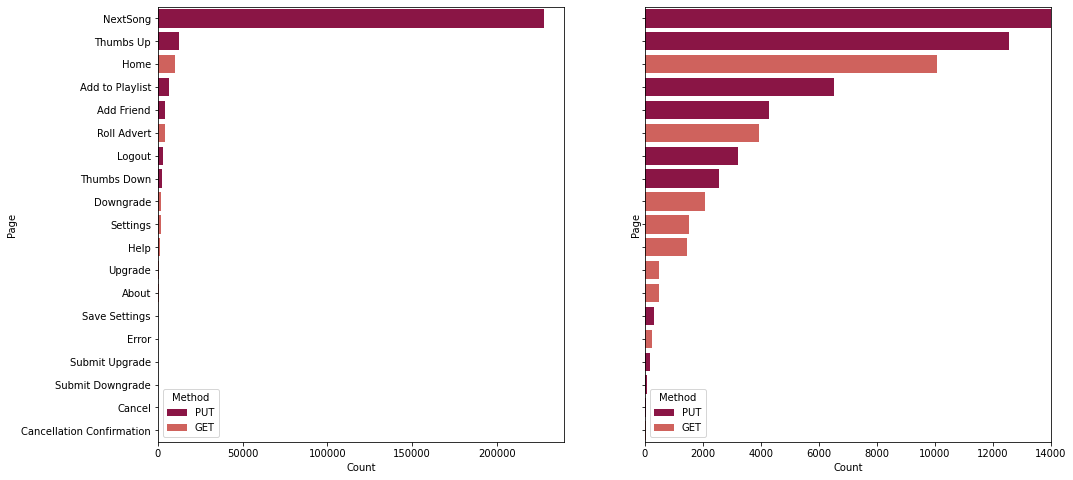

In [19]:
pages_count = df_clean.groupby('page','method').count()

# absolute number of page types
print('There are {} different page types.'.format(pages_count.count()))

# visualization
plot_bar_chart_grouped(df=pages_count, x_col='count', y_col='page', group='method', dodge=False, y_lim=14000)

### Browser

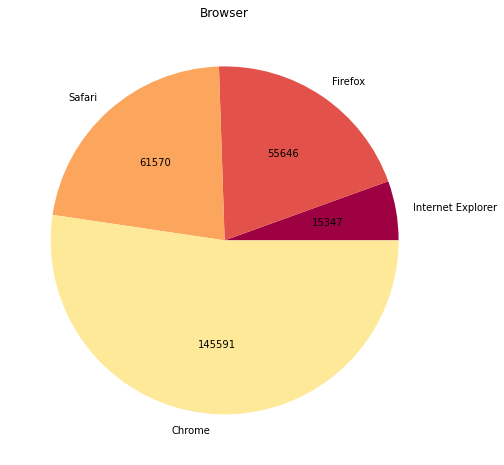

In [20]:
browser = df_clean.groupby('browser').count()
    
plot_pie_chart(browser,'count','browser')

### Device/OS

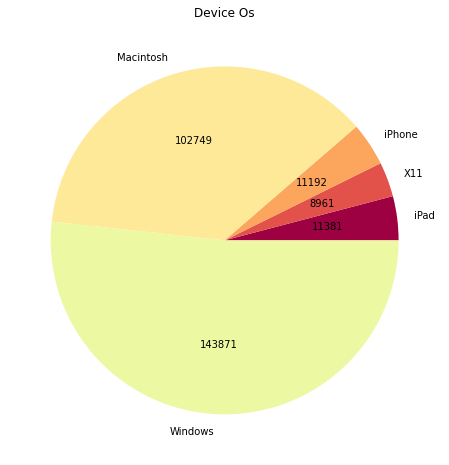

In [21]:
device_os = df_clean.groupby('device_os').count()
    
plot_pie_chart(device_os,'count','device_os')

### Level

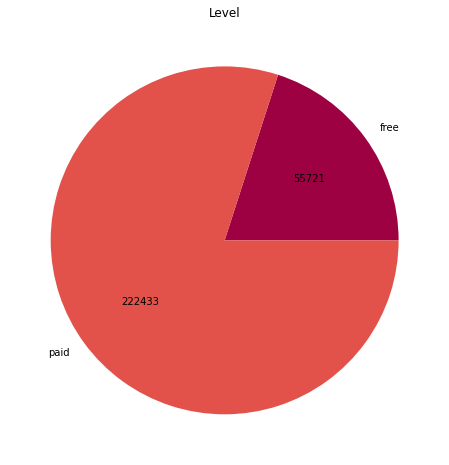

In [22]:
level = df_clean.groupby('level').count()
    
plot_pie_chart(level,'count','level')

### Gender

In [21]:
gender_user_combination = df_clean.select('gender','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if gender_user_combination == unique_users:
    print('Each user is associated with a unique gender in the dataset.')
else:
    print('There are {} gender x user combinations more than there are unique users.'.format(gender_user_combination-unique_users))

Each user is associated with a unique gender in the dataset.


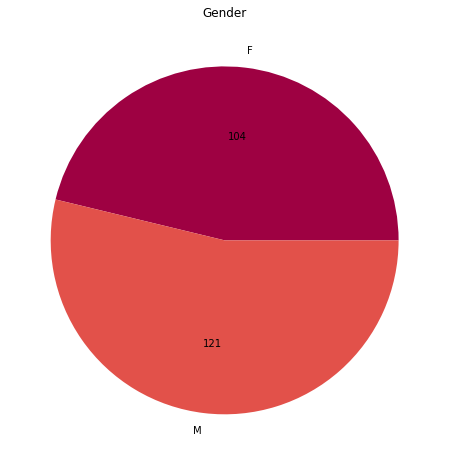

In [23]:
gender = df_clean.select('gender','userId') \
                 .dropDuplicates() \
                 .groupby('gender') \
                 .count()

plot_pie_chart(gender,'count','gender')

### State

In [23]:
state_user_combination = df_clean.select('state','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if state_user_combination == unique_users:
    print('Each user is associated with a unique state in the dataset.')
else:
    print('There are {} state x user combinations more than there are unique users.'.format(state_user_combination-unique_users))

Each user is associated with a unique state in the dataset.


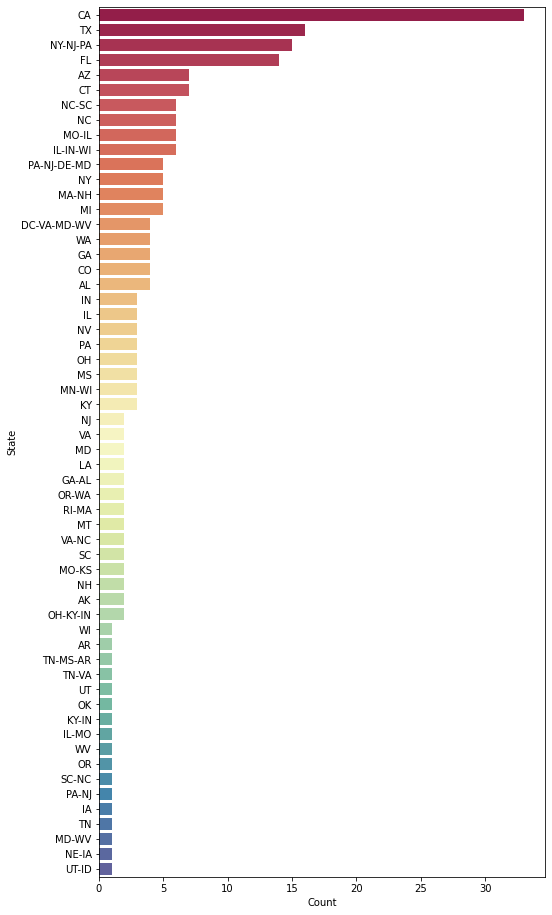

In [24]:
state = df_clean.select('state','userId') \
                 .dropDuplicates() \
                 .groupby('state') \
                 .count()

plot_bar_chart(state,'count','state', size=(8,16), color='Spectral')

### Unique Sessions per User

+-------+------------------------+
|summary|unique_sessions_per_user|
+-------+------------------------+
|  count|                     225|
|   mean|      14.115555555555556|
| stddev|      14.646884657111562|
|    min|                       1|
|    max|                     107|
+-------+------------------------+



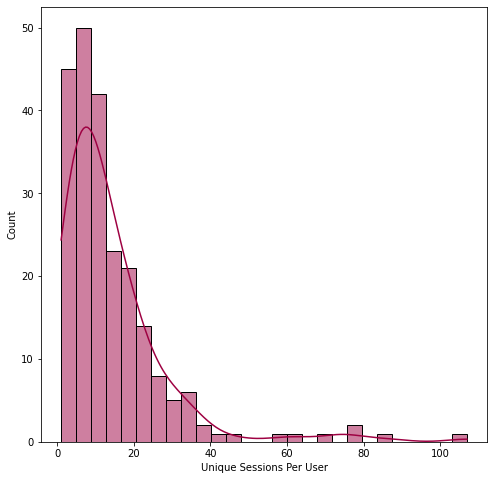

In [45]:
sessions_per_user = df_clean.select('userId','sessionId') \
                            .dropDuplicates() \
                            .groupby('userId') \
                            .count() \
                            .withColumnRenamed('count', 'unique_sessions_per_user')

# descriptives
show_descriptives(sessions_per_user, 'unique_sessions_per_user')
        
# visualization
plot_histogram(sessions_per_user, 'unique_sessions_per_user')

### Items per Session

+-------+------------------+
|summary| items_per_session|
+-------+------------------+
|  count|              2312|
|   mean| 108.4757785467128|
| stddev|123.76252480420018|
|    min|                 0|
|    max|              1321|
+-------+------------------+



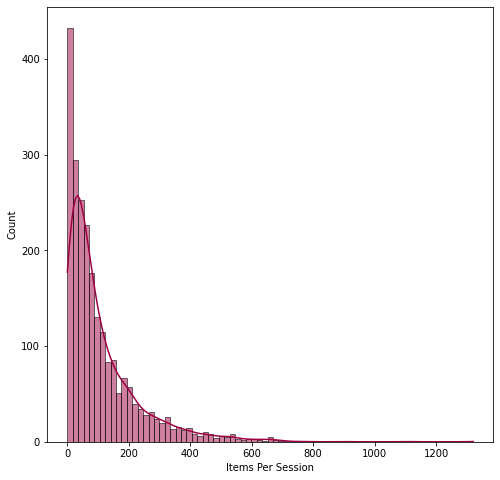

In [46]:
items_per_session = df_clean.groupby('sessionId') \
                            .agg({'itemInSession':'max'}) \
                            .withColumnRenamed('max(itemInSession)', 'items_per_session')

# descriptives
show_descriptives(items_per_session, 'items_per_session')
        
# visualization
plot_histogram(items_per_session, 'items_per_session')

### Length per Item or Session

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|           228108|
|   mean|249.1171819778458|
| stddev|99.23517921058361|
|    min|          0.78322|
|    max|       3024.66567|
+-------+-----------------+



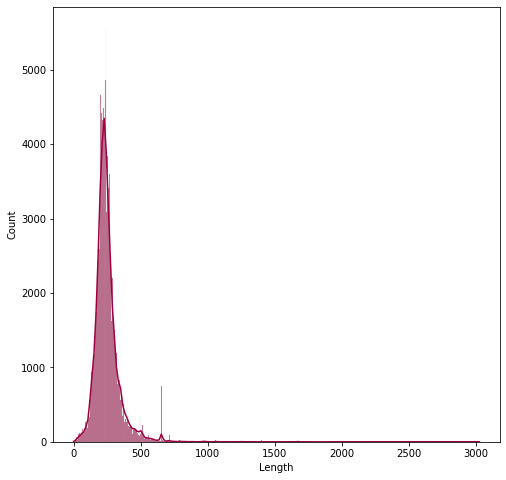

In [47]:
length_per_item = df_clean.filter(col('length').isNotNull()).select('length')

# descriptives
show_descriptives(length_per_item, 'length')
        
# visualization
plot_histogram(length_per_item, 'length')

+-------+------------------------+
|summary|total_length_per_session|
+-------+------------------------+
|  count|                    2253|
|   mean|      25222.202461873054|
| stddev|      28117.169683359738|
|    min|               153.46893|
|    max|       267758.1329100001|
+-------+------------------------+



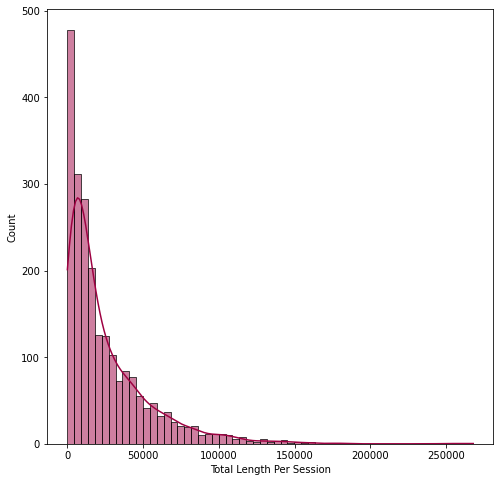

In [48]:
length_per_session = df_clean.filter(col('length').isNotNull()) \
                             .groupby('sessionId') \
                             .agg({'length':'sum'}) \
                             .withColumnRenamed('sum(length)', 'total_length_per_session')

# descriptives
show_descriptives(length_per_session, 'total_length_per_session')
        
# visualization
plot_histogram(length_per_session, 'total_length_per_session')

### Days Since Registration

+-------+-----------------------+
|summary|days_since_registration|
+-------+-----------------------+
|  count|                    225|
|   mean|      79.81777777777778|
| stddev|      37.62535766849984|
|    min|                      0|
|    max|                    256|
+-------+-----------------------+



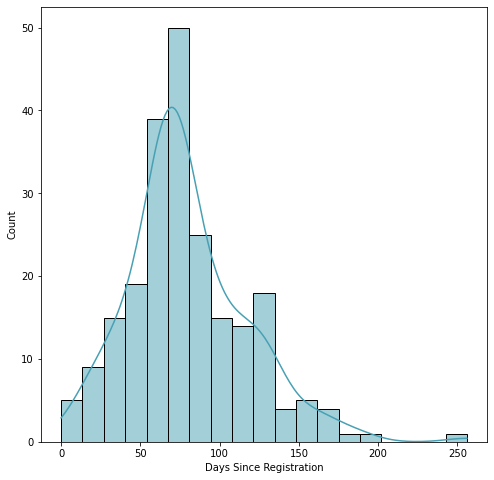

In [35]:
days_since_registration_per_user = df_clean.select('userId','days_since_registration') \
                            .groupby('userId') \
                            .agg({'days_since_registration':'max'}) \
                            .withColumnRenamed('max(days_since_registration)', 'days_since_registration')

# descriptives
show_descriptives(days_since_registration_per_user, 'days_since_registration')
        
# visualization
plot_histogram(days_since_registration_per_user, 'days_since_registration')

### Seasonality

In [27]:
df_clean.groupby('date').count().sort('date').collect()

[Row(date='2018-10-01', count=4286),
 Row(date='2018-10-02', count=4453),
 Row(date='2018-10-03', count=3966),
 Row(date='2018-10-04', count=4645),
 Row(date='2018-10-05', count=4485),
 Row(date='2018-10-06', count=3711),
 Row(date='2018-10-07', count=2937),
 Row(date='2018-10-08', count=5137),
 Row(date='2018-10-09', count=5474),
 Row(date='2018-10-10', count=6178),
 Row(date='2018-10-11', count=5623),
 Row(date='2018-10-12', count=5398),
 Row(date='2018-10-13', count=2975),
 Row(date='2018-10-14', count=2629),
 Row(date='2018-10-15', count=5153),
 Row(date='2018-10-16', count=5802),
 Row(date='2018-10-17', count=5235),
 Row(date='2018-10-18', count=5370),
 Row(date='2018-10-19', count=5545),
 Row(date='2018-10-20', count=5697),
 Row(date='2018-10-21', count=3036),
 Row(date='2018-10-22', count=4888),
 Row(date='2018-10-23', count=4300),
 Row(date='2018-10-24', count=5667),
 Row(date='2018-10-25', count=4993),
 Row(date='2018-10-26', count=4296),
 Row(date='2018-10-27', count=3500),
 

**Conclusion:** Seasonality cannot be properly investigated on the small dataset since it includes 2 full months only.

### Time Series of Page Types

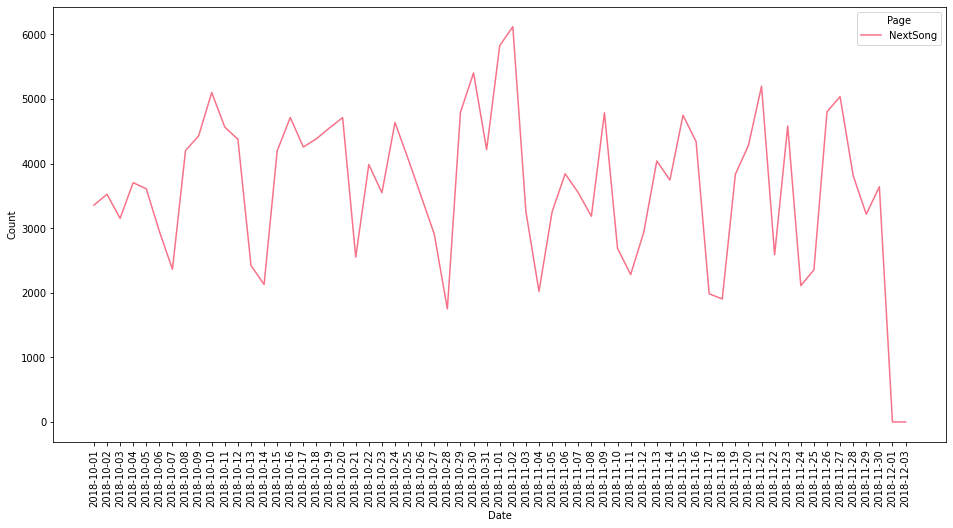

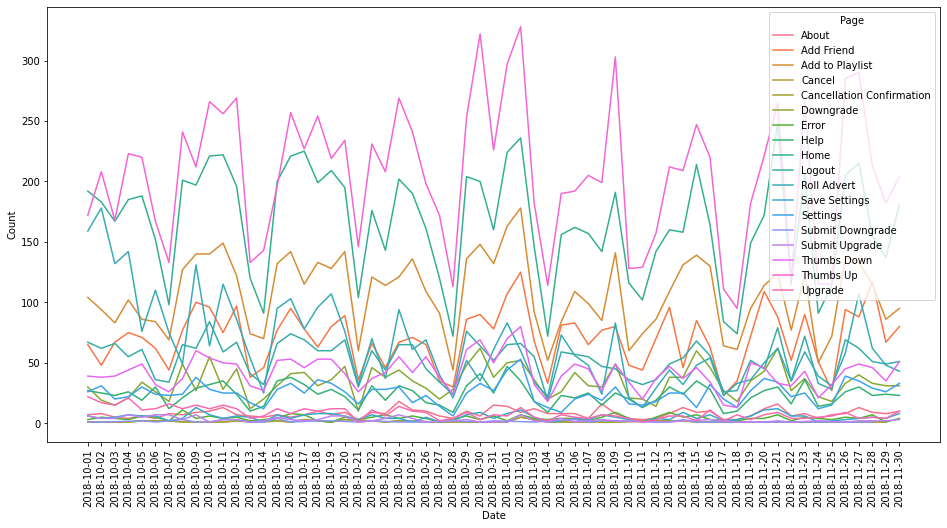

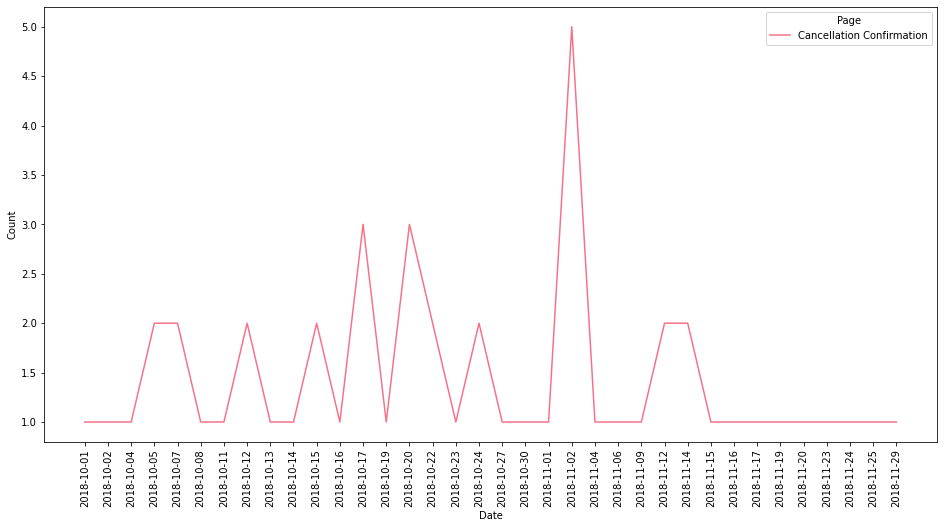

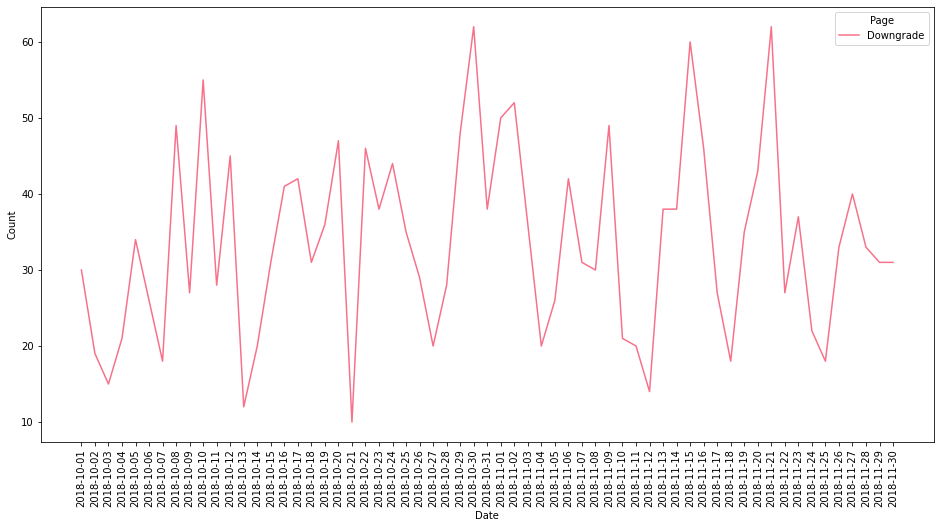

In [29]:
# plot page type 'NextSong' only
events_per_day = df_clean.filter(col('page')=='NextSong').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot all page types except 'NextSong'
events_per_day = df_clean.filter(col('page')!='NextSong').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_day = df_clean.filter(col('page')=='Cancellation Confirmation').groupby('date','page').count().sort('date','page')

plot_line_chart(events_per_day, 'date', 'count', 'page')

### Weekday Time Series of Page Type

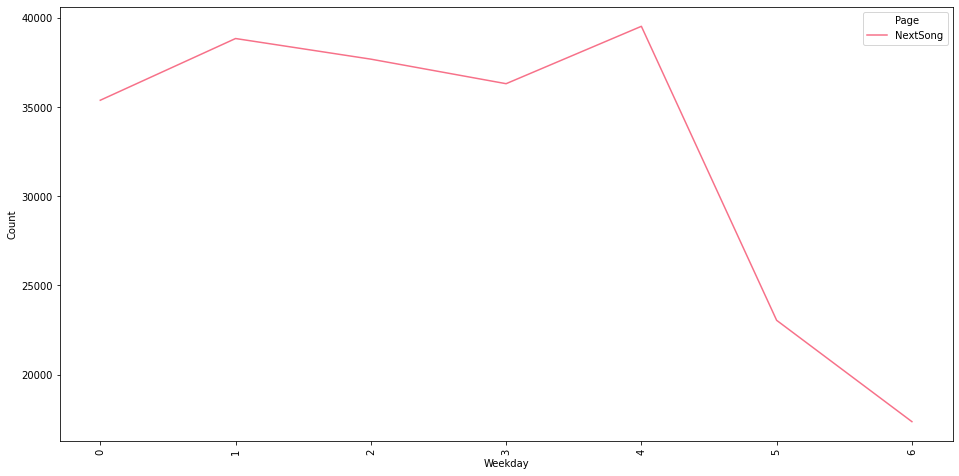

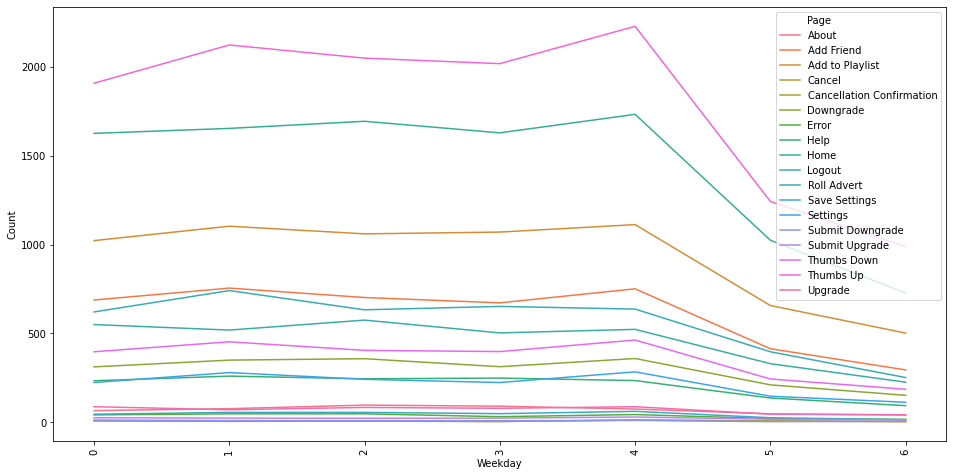

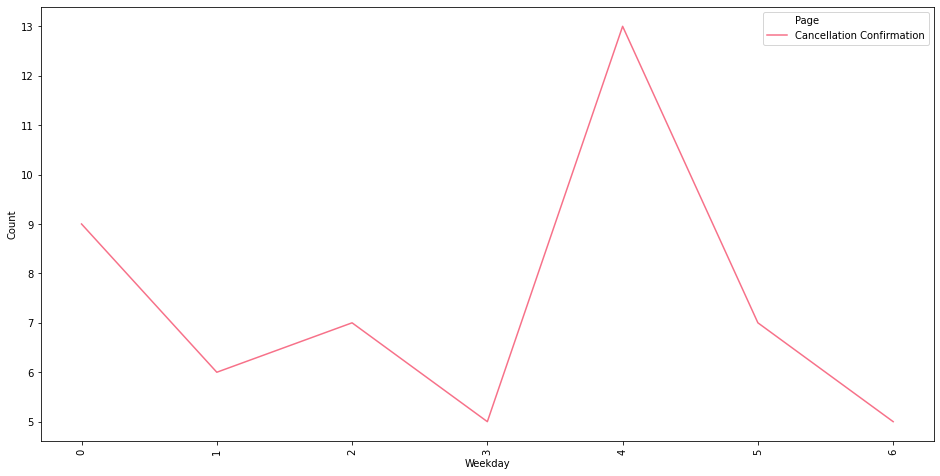

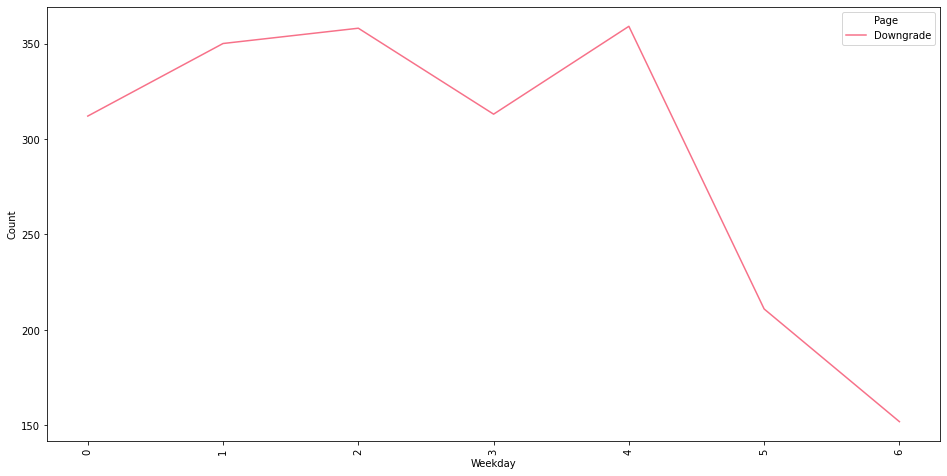

In [23]:
# plot page type 'NextSong' only
events_per_weekday = df_clean.filter(col('page')=='NextSong').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot all page types except 'NextSong'
events_per_weekday = df_clean.filter(col('page')!='NextSong').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_weekday = df_clean.filter(col('page')=='Cancellation Confirmation').groupby('weekday','page').count().sort('weekday','page')

plot_line_chart(events_per_weekday, 'weekday', 'count', 'page')

### Hourly Time Series of Page Types

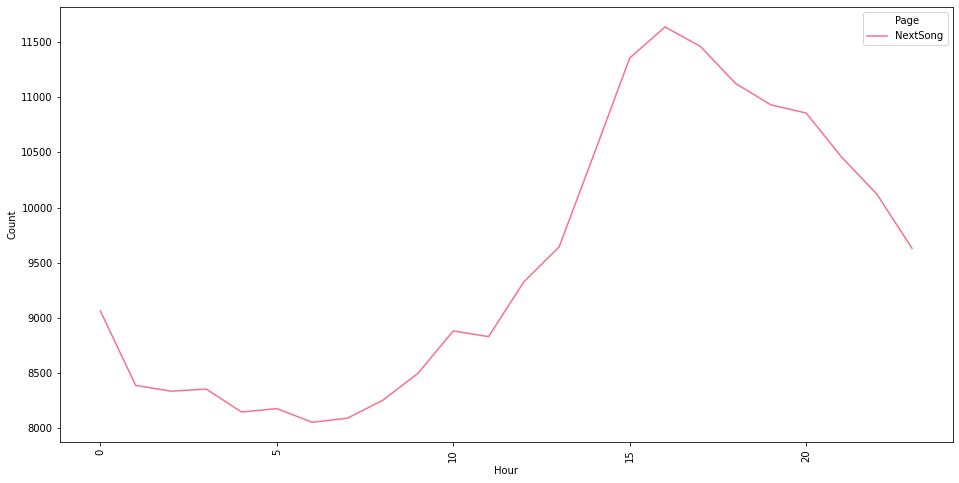

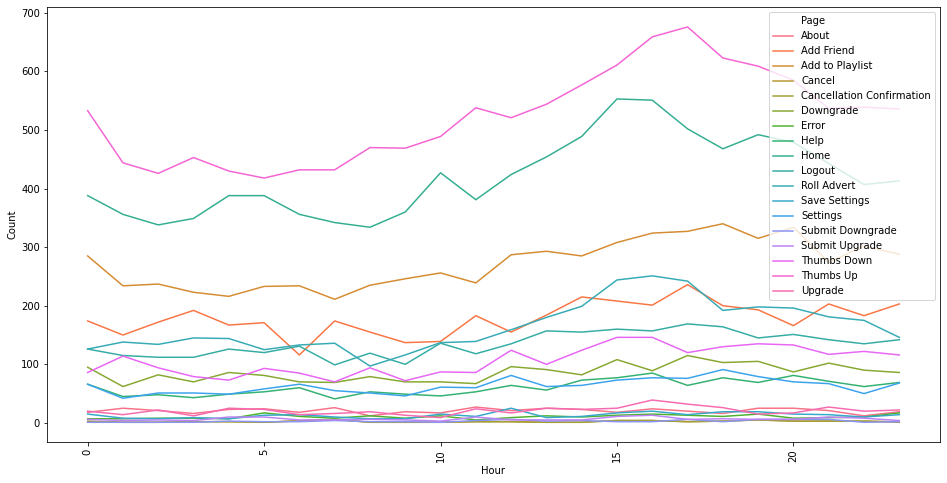

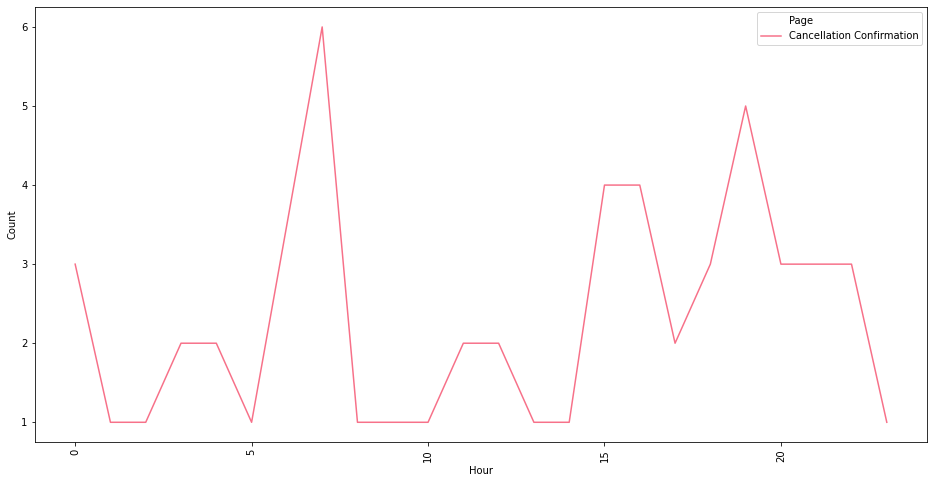

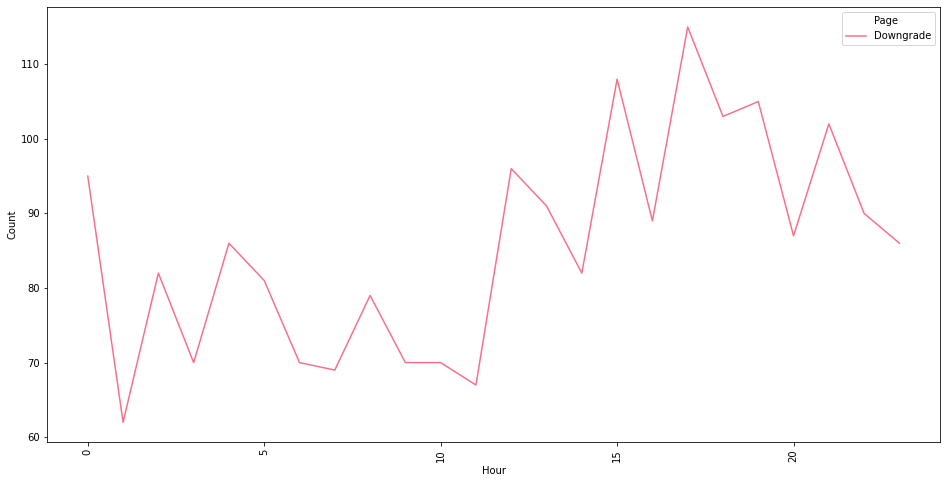

In [24]:
# plot page type 'NextSong' only
events_per_hour = df_clean.filter(col('page')=='NextSong').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot all page types except 'NextSong'
events_per_hour = df_clean.filter(col('page')!='NextSong').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

#plot page type 'Cancellation Confirmation'
events_per_hour = df_clean.filter(col('page')=='Cancellation Confirmation').groupby('hour','page').count().sort('hour','page')

plot_line_chart(events_per_hour, 'hour', 'count', 'page')

### Time Series of Registration

In [30]:
registration_user_combination = df_clean.select('registration_datetime','userId').dropDuplicates().count()
unique_users = df_clean.select('userId').dropDuplicates().count()

if registration_user_combination == unique_users:
    print('Each user is associated with a unique registration datetime in the dataset.')
else:
    print('There are {} registration datetime x user combinations more than there are unique users.'.format(registration_user_combination-unique_users))

Each user is associated with a unique registration datetime in the dataset.


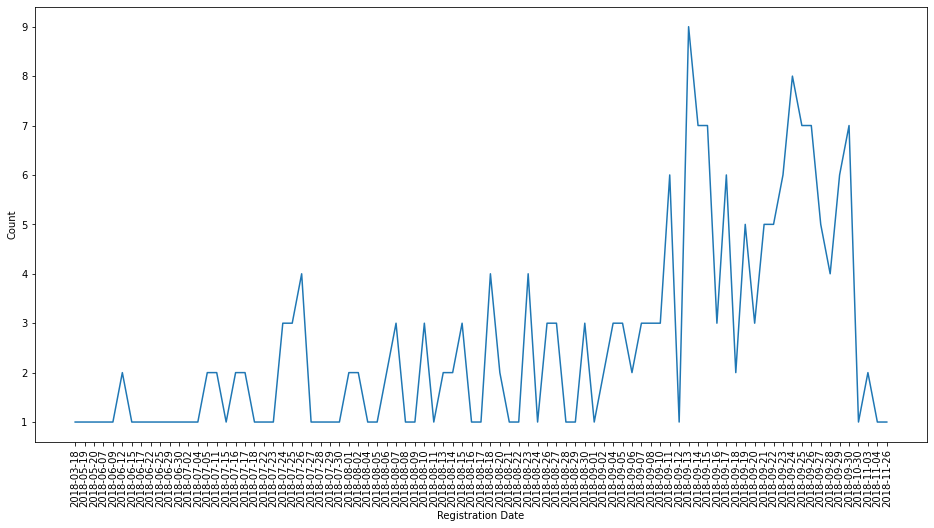

In [31]:
users_per_registration_day = df_clean.select('userId','registration_date') \
                                     .dropDuplicates() \
                                     .groupby('registration_date') \
                                     .count() \
                                     .sort('registration_date')

plot_line_chart(users_per_registration_day, 'registration_date', 'count', legend=None)

### Weekday Time Series of Registration

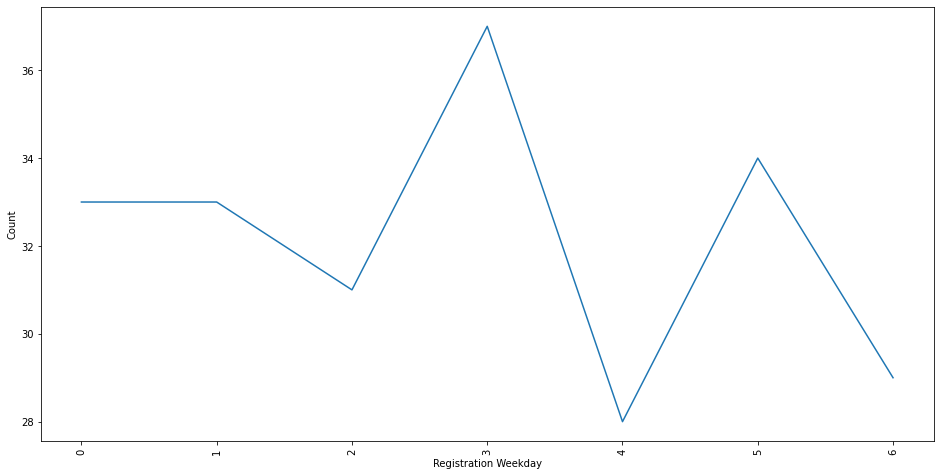

In [32]:
users_per_registration_weekday = df_clean.select('userId','registration_weekday') \
                                     .dropDuplicates() \
                                     .groupby('registration_weekday') \
                                     .count() \
                                     .sort('registration_weekday')

plot_line_chart(users_per_registration_weekday, 'registration_weekday', 'count', legend=None)

### Hourly Time Series of Registration

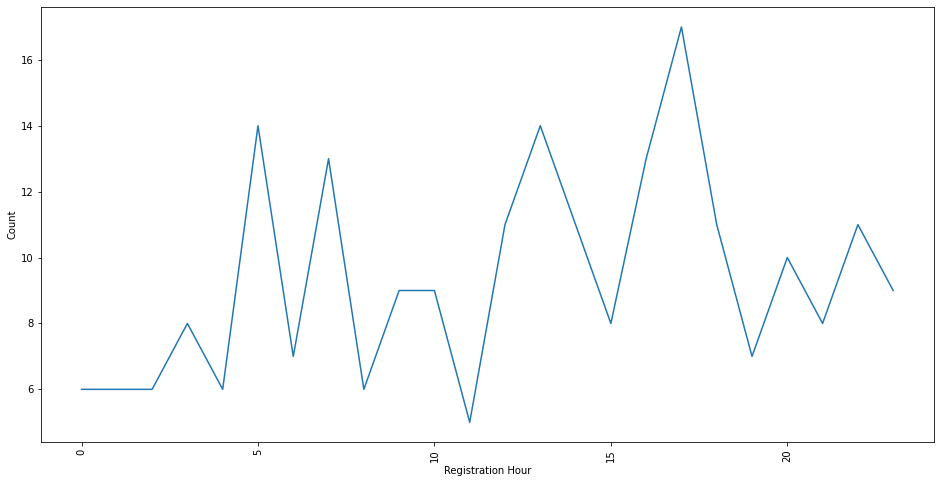

In [33]:
users_per_registration_hour = df_clean.select('userId','registration_hour') \
                                      .dropDuplicates() \
                                      .groupby('registration_hour') \
                                      .count() \
                                      .sort('registration_hour')

plot_line_chart(users_per_registration_hour, 'registration_hour', 'count', legend=None)

### Churn Definition

A column `churn` is created to use as the label for a user churn prediction model. All events with page = `Cancellation Confirmation` will be regarded as **churn events** regardless of free or paid subscription.

In [20]:
# churn events & users
df_clean.filter(col('page')=='Cancellation Confirmation') \
        .groupby('page','level') \
        .count() \
        .sort('page','level') \
        .withColumnRenamed('count', 'event_count') \
        .show() 

df_clean.filter(col('page')=='Cancellation Confirmation').select('page','level','userId') \
                 .dropDuplicates() \
                 .groupby('page','level') \
                 .count() \
                 .withColumnRenamed('count', 'user_count') \
                 .show()

+--------------------+-----+-----------+
|                page|level|event_count|
+--------------------+-----+-----------+
|Cancellation Conf...| free|         21|
|Cancellation Conf...| paid|         31|
+--------------------+-----+-----------+

+--------------------+-----+----------+
|                page|level|user_count|
+--------------------+-----+----------+
|Cancellation Conf...| free|        21|
|Cancellation Conf...| paid|        31|
+--------------------+-----+----------+

+---------+-----+-----------+
|     page|level|event_count|
+---------+-----+-----------+
|Downgrade| paid|       2055|
+---------+-----+-----------+

+---------+-----+----------+
|     page|level|user_count|
+---------+-----+----------+
|Downgrade| paid|       154|
+---------+-----+----------+



In [36]:
# prepare function to mark users according to page types

def mark_users(df, page_type, new_col_name, user_col):
    '''
    '''
    # user defined function to find 'Cancellation Confirmation' events
    mark_events = udf(lambda x : 1 if x==page_type else 0, IntegerType())

    # create new column by applying mark_events to column 'page' - EVENT LEVEL
    df_events = df.withColumn(new_col_name, mark_events(df['page']))

    # modify new column by applying a window function - USER LEVEL
    users_window = Window.partitionBy(user_col).rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)
    df_users = df_events.withColumn(new_col_name, max(new_col_name).over(users_window))
    
    return df_users

In [37]:
df_clean = mark_users(df_clean, 'Cancellation Confirmation', 'churn', 'userId')

churn_list = []
for idx in df_clean.select('userId','churn') \
                   .dropDuplicates() \
                   .groupby('churn') \
                   .count() \
                   .sort('churn') \
                   .collect():
    churn_list.append(idx['count'])
    

print('{} % user churn.\n'.format('{:.0f}'.format(churn_list[1] / sum(churn_list) * 100)))

print('Example of a churn user:')
df_clean.filter(col('userId')=='125').select('userId','datetime','page','churn').show()

print('Example of a non-churn user:')
df_clean.filter(col('userId')=='156').select('userId','datetime','page','churn').show()

23 % user churn.

Example of a churn user:
+------+-------------------+--------------------+-----+
|userId|           datetime|                page|churn|
+------+-------------------+--------------------+-----+
|   125|2018-10-12 04:05:44|            NextSong|    1|
|   125|2018-10-12 04:11:21|            NextSong|    1|
|   125|2018-10-12 04:15:11|            NextSong|    1|
|   125|2018-10-12 04:18:34|            NextSong|    1|
|   125|2018-10-12 04:22:04|            NextSong|    1|
|   125|2018-10-12 04:28:35|            NextSong|    1|
|   125|2018-10-12 04:32:08|            NextSong|    1|
|   125|2018-10-12 04:35:06|            NextSong|    1|
|   125|2018-10-12 04:35:17|         Roll Advert|    1|
|   125|2018-10-12 04:35:18|              Cancel|    1|
|   125|2018-10-12 04:35:18|Cancellation Conf...|    1|
+------+-------------------+--------------------+-----+

Example of a non-churn user:
+------+-------------------+-----------+-----+
|userId|           datetime|       page|

### Page Types

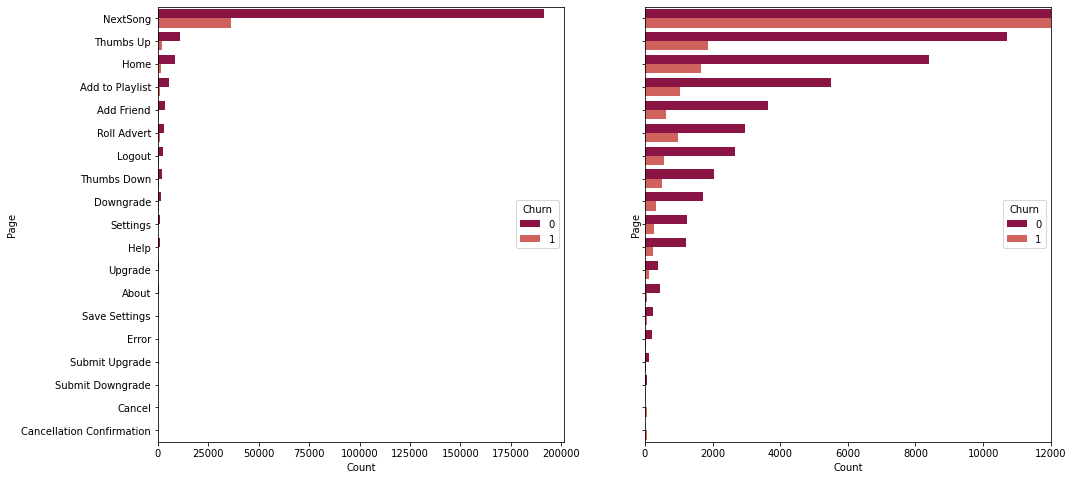

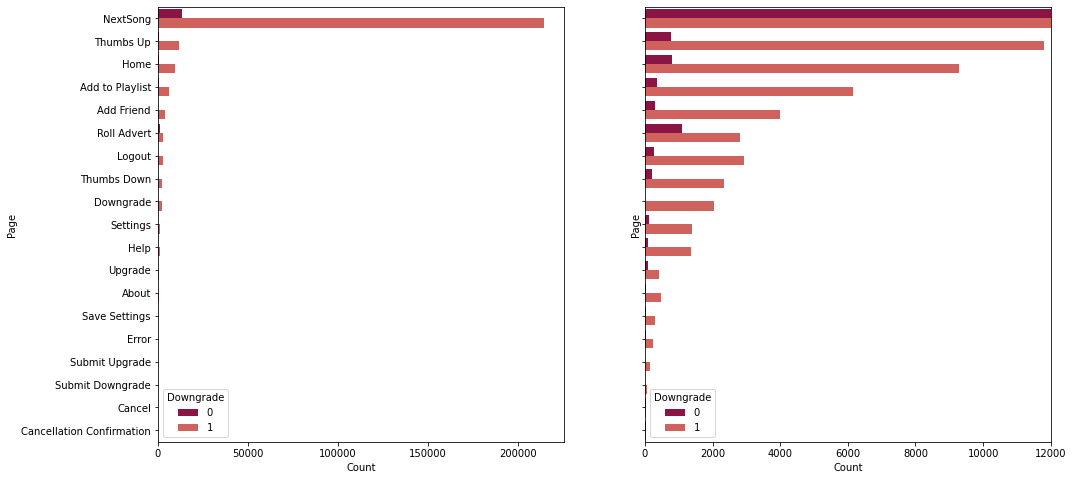

In [39]:
for i in ['churn']:
    pages_count = df_clean.groupby('page',i).count()

    # visualization
    plot_bar_chart_grouped(df=pages_count,x_col='count',y_col='page',group=i, y_lim=12000)

### Browser

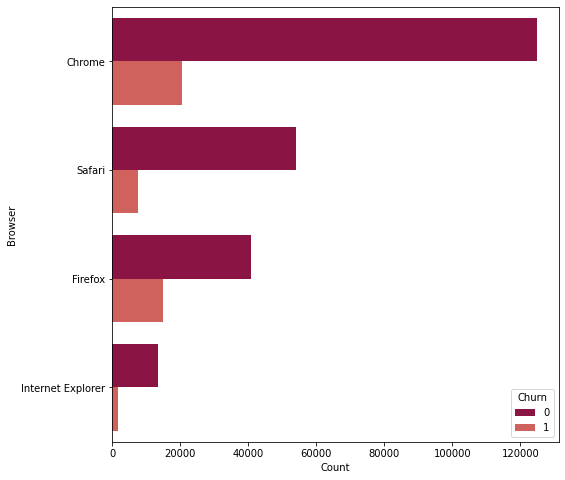

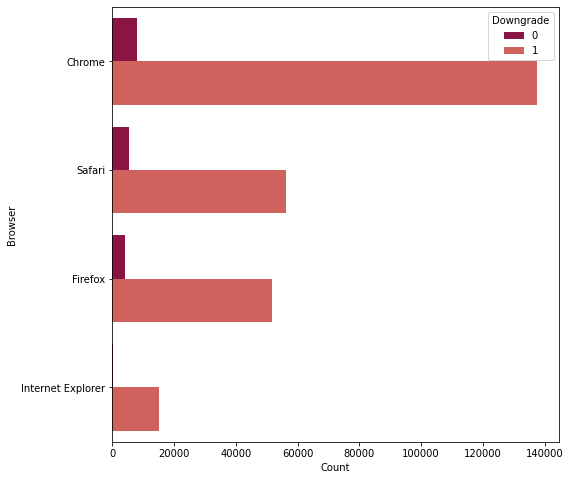

In [25]:
for i in ['churn']:
    browser_count = df_clean.groupby('browser',i).count()

    # visualization
    plot_bar_chart_grouped(df=browser_count,x_col='count',y_col='browser',group=i, subplots=1, size=(8,8))

### Device/OS

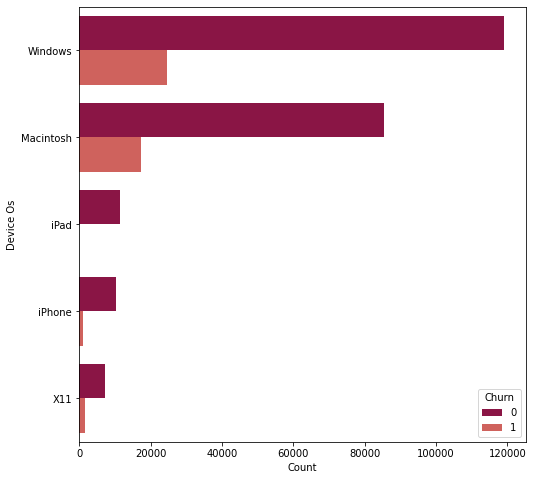

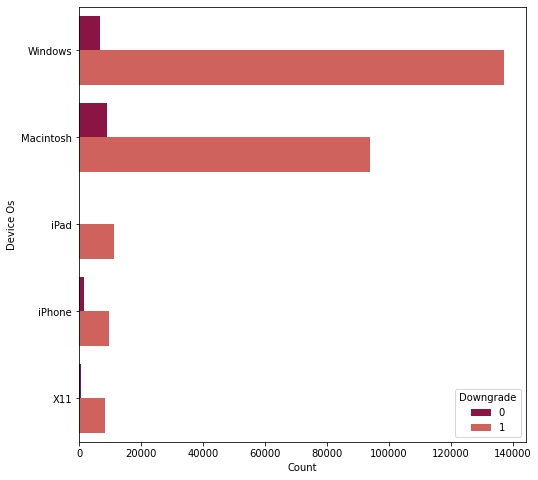

In [26]:
for i in ['churn']:
    device_os_count = df_clean.groupby('device_os',i).count()

    # visualization
    plot_bar_chart_grouped(df=device_os_count,x_col='count',y_col='device_os',group=i, subplots=1, size=(8,8))

### Level

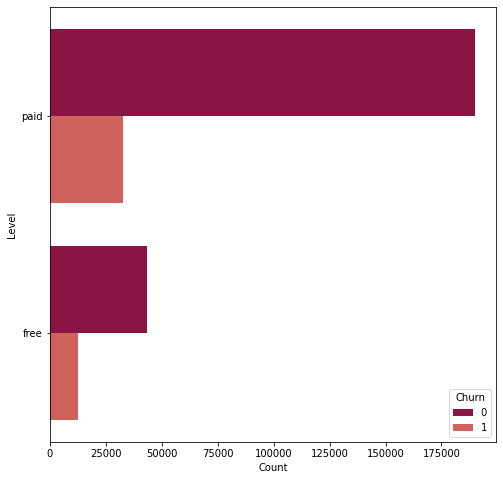

In [27]:
for i in ['churn']:
    level_count = df_clean.groupby('level',i).count()

    # visualization
    plot_bar_chart_grouped(df=level_count,x_col='count',y_col='level', group=i, subplots=1, size=(8,8))

### Gender

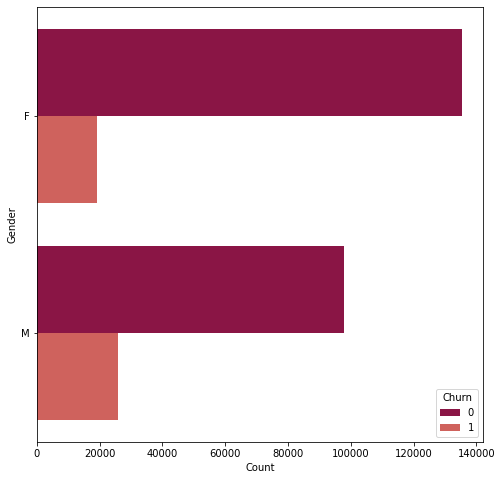

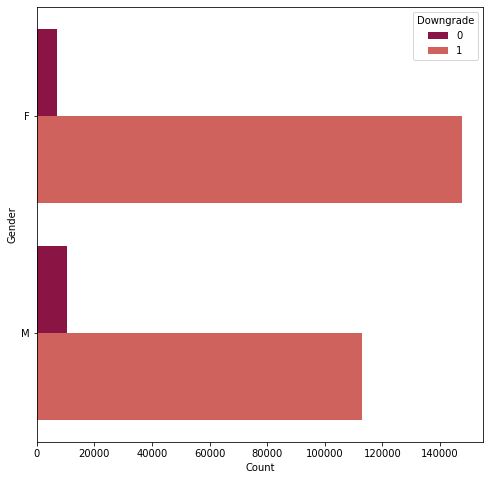

In [28]:
for i in ['churn']:
    gender_count = df_clean.groupby('gender',i).count()

    # visualization
    plot_bar_chart_grouped(df=gender_count,x_col='count',y_col='gender',group=i, subplots=1, size=(8,8))

### Location

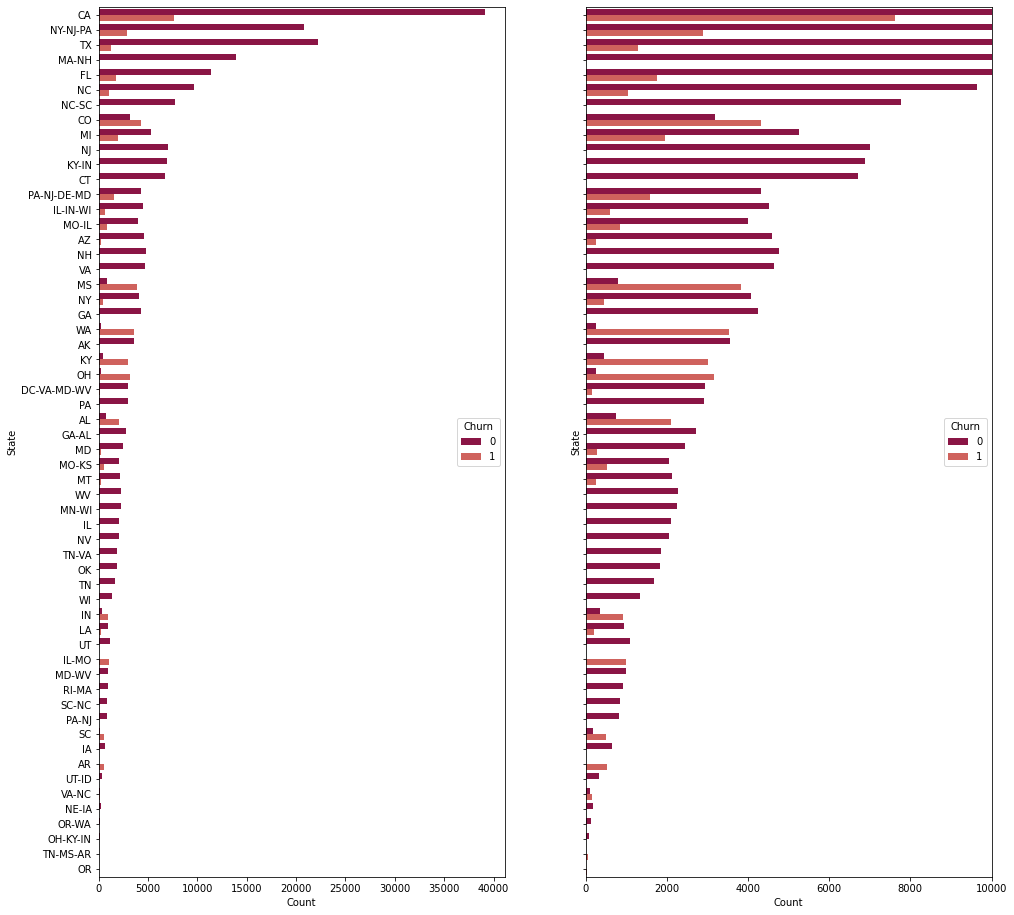

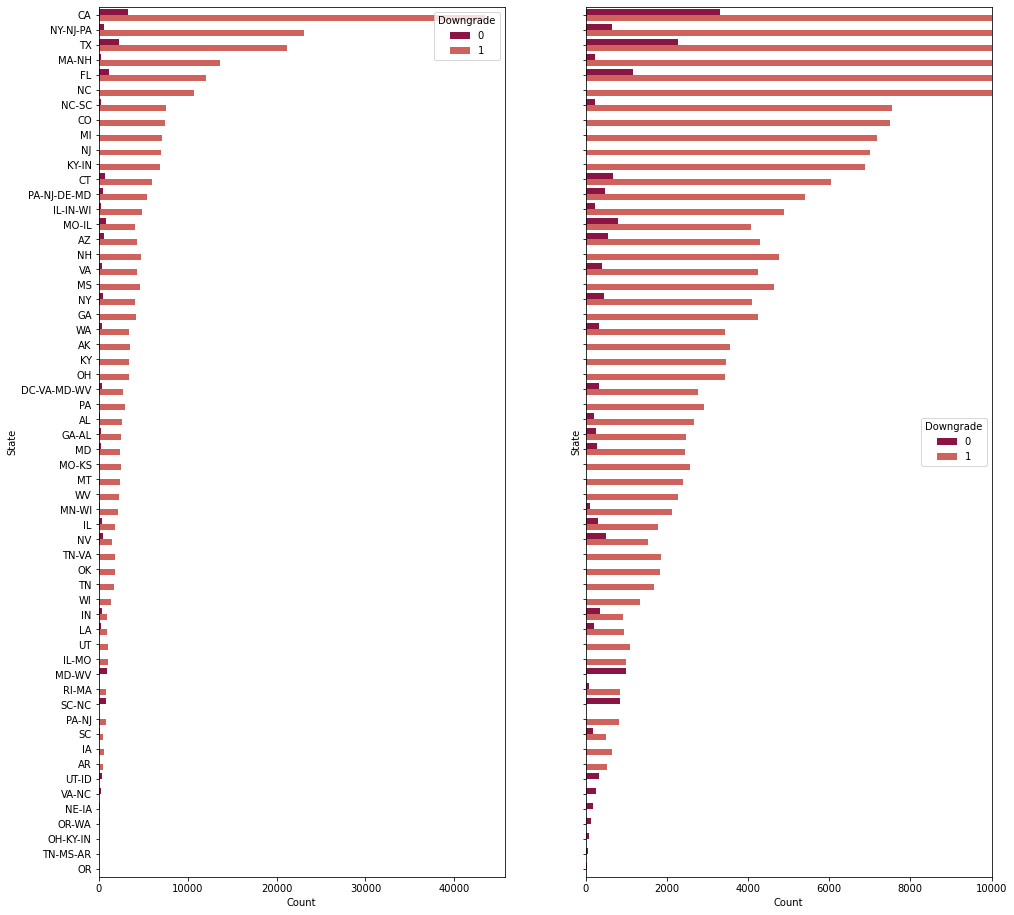

In [29]:
for i in ['churn']:
    state_count = df_clean.groupby('state',i).count()

    # visualization
    plot_bar_chart_grouped(df=state_count,x_col='count',y_col='state',group=i, size=(16,16), y_lim=10000)

### Unique Sessions per User

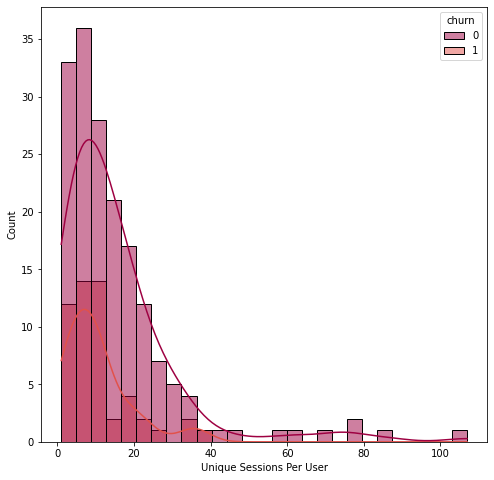

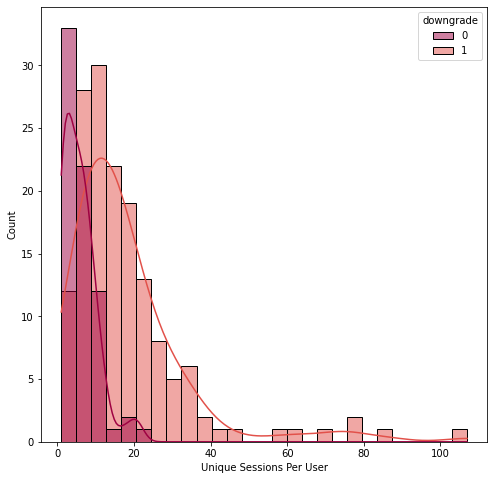

In [40]:
for i in ['churn']:
    sessions_per_user = df_clean.select('userId',i,'sessionId') \
                                .dropDuplicates() \
                                .groupby('userId',i) \
                                .count() \
                                .withColumnRenamed('count', 'unique_sessions_per_user')

    # visualization
    plot_histogram_grouped(sessions_per_user, 'unique_sessions_per_user', i, 2)

### Items per Session

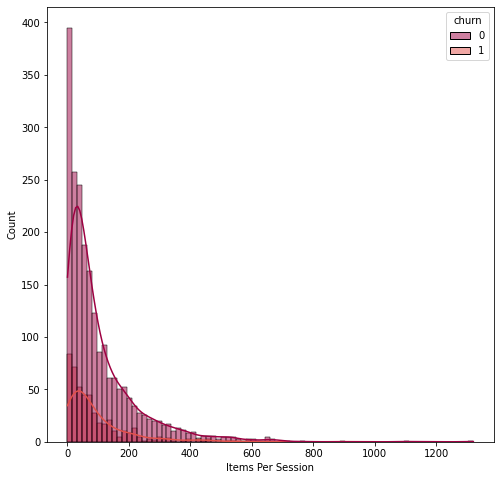

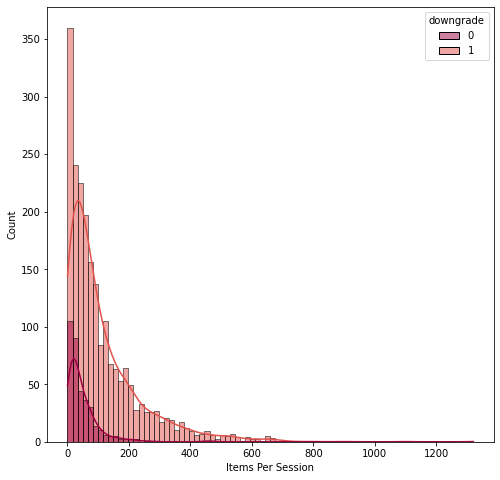

In [79]:
for i in ['churn']:
    items_per_session = df_clean.groupby('sessionId',i) \
                            .agg({'itemInSession':'max'}) \
                            .withColumnRenamed('max(itemInSession)', 'items_per_session')

    # visualization
    plot_histogram_grouped(items_per_session, 'items_per_session', i, 2)

### Length per Item or Session

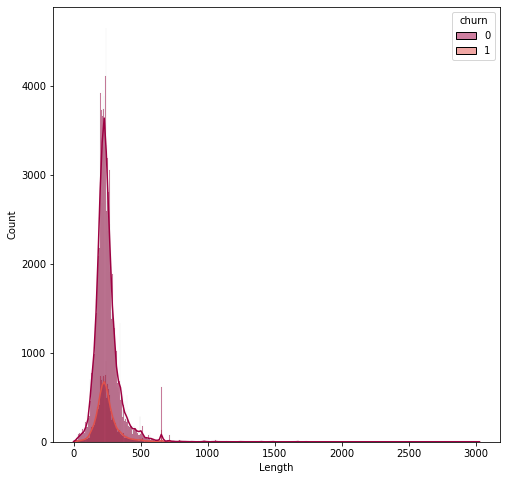

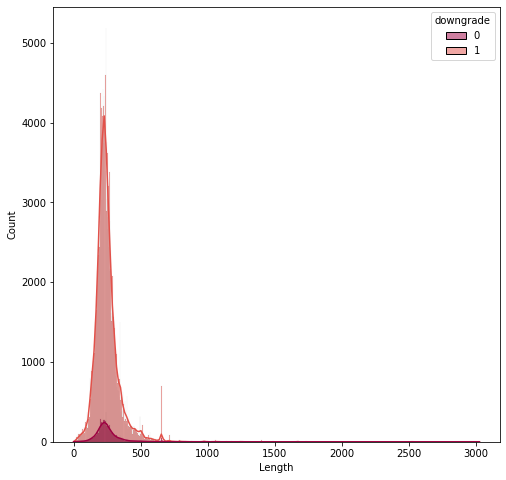

In [80]:
for i in ['churn']:
    length_per_item = df_clean.filter(col('length').isNotNull()).select('length',i)

    # visualization
    plot_histogram_grouped(length_per_item, 'length', i, 2)

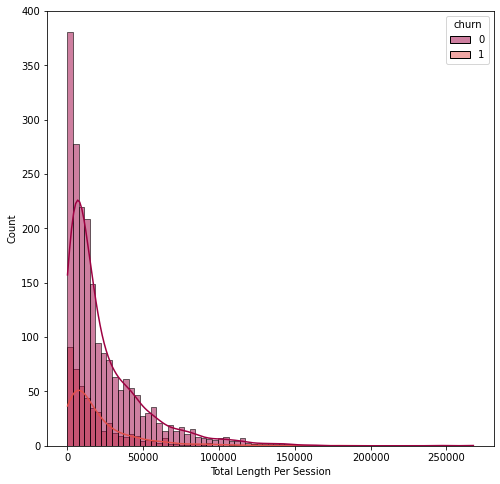

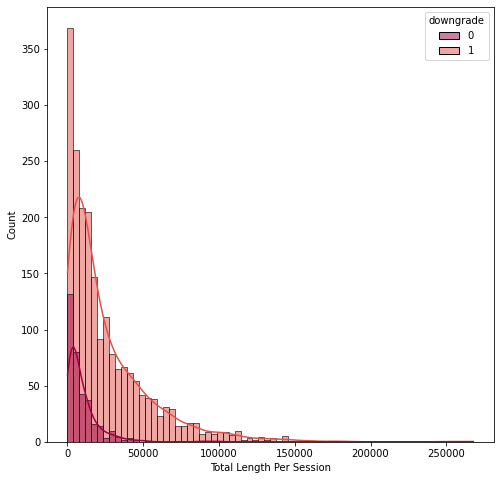

In [81]:
for i in ['churn']:
    length_per_session = df_clean.filter(col('length').isNotNull()) \
                             .groupby('sessionId',i) \
                             .agg({'length':'sum'}) \
                             .withColumnRenamed('sum(length)', 'total_length_per_session')

    # visualization
    plot_histogram_grouped(length_per_session, 'total_length_per_session', i, 2)

### Days Since Registration

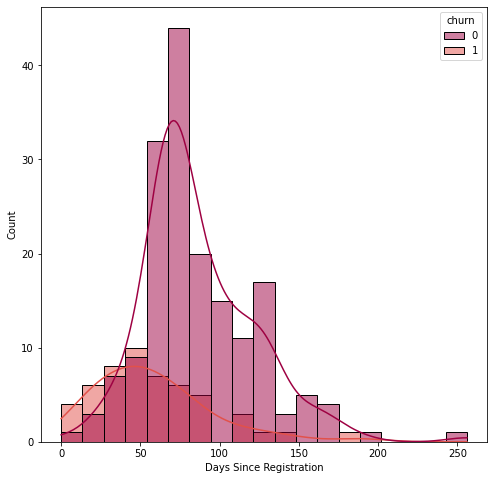

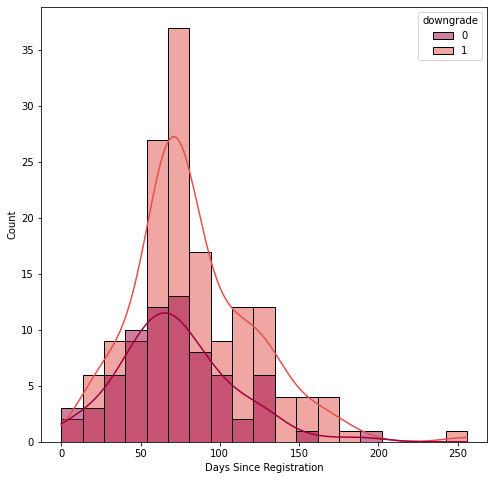

In [43]:
for i in ['churn']:
    days_since_registration_per_user = df_clean.select('userId','days_since_registration',i) \
                            .groupby('userId',i) \
                            .agg({'days_since_registration':'max'}) \
                            .withColumnRenamed('max(days_since_registration)', 'days_since_registration')

    # visualization
    plot_histogram_grouped(days_since_registration_per_user, 'days_since_registration', i, 2)

### Time Series

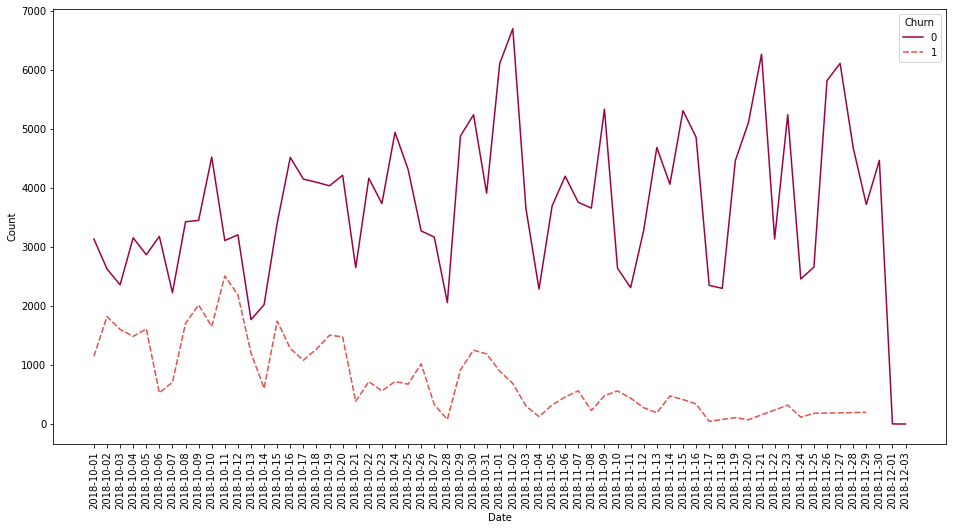

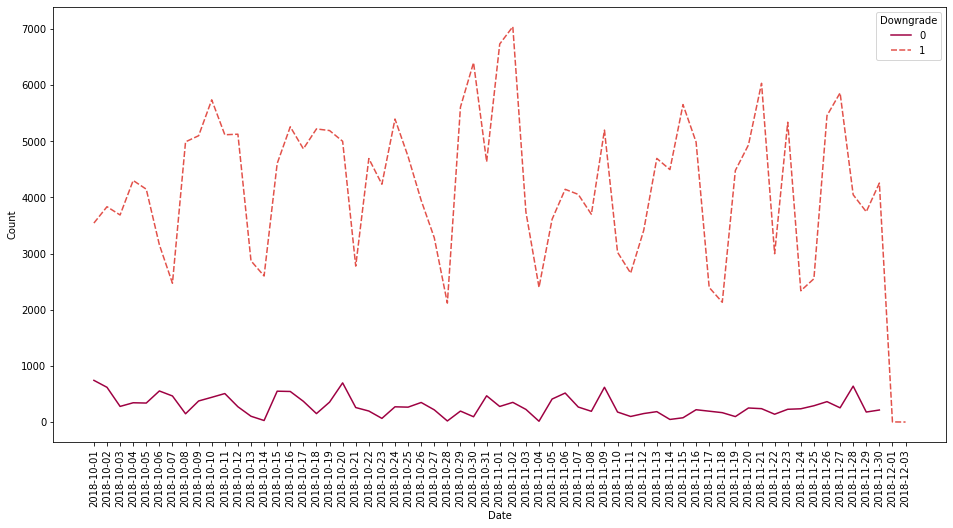

In [41]:
for i in ['churn']:
    events_per_day = df_clean.groupby('date',i).count().sort('date',i)

    plot_line_chart(events_per_day, 'date', 'count', i, line_style=i, color=colors[:2])

### Weekday Series

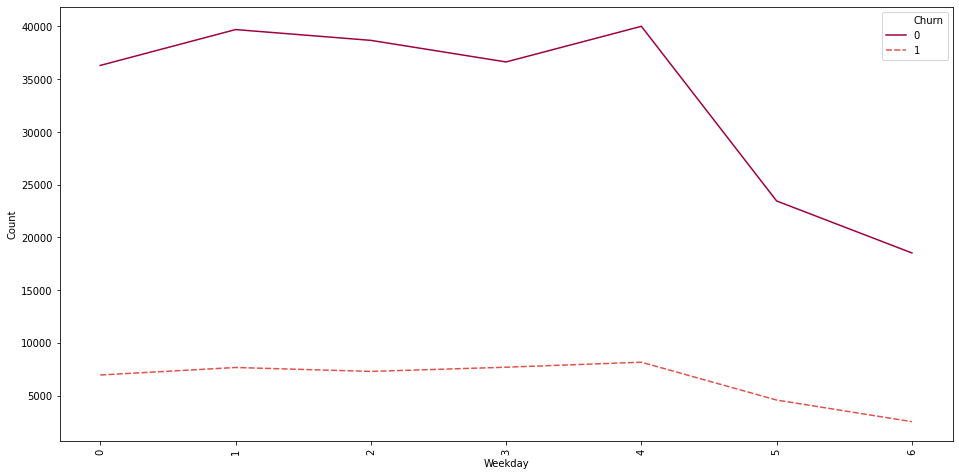

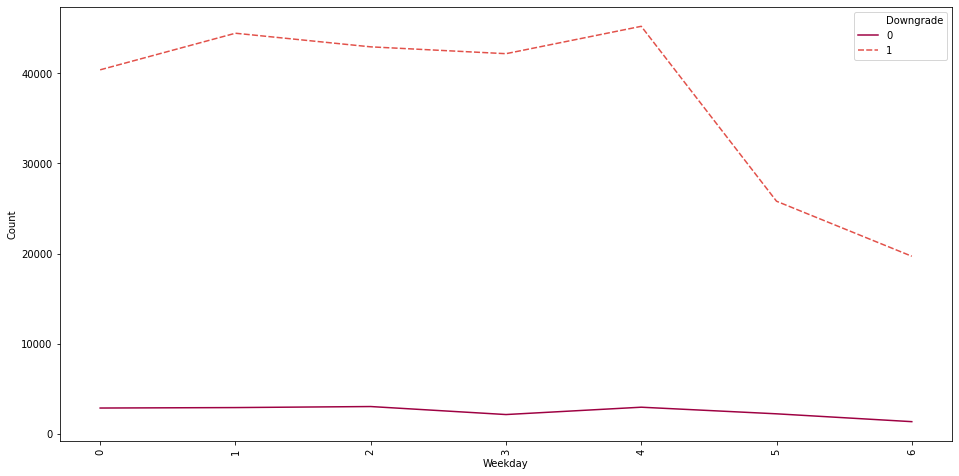

In [32]:
for i in ['churn']:
    events_per_weekday = df_clean.groupby('weekday',i).count().sort('weekday',i)

    plot_line_chart(events_per_weekday, 'weekday', 'count', i, line_style=i, color=colors[:2])

### Hourly Time Series

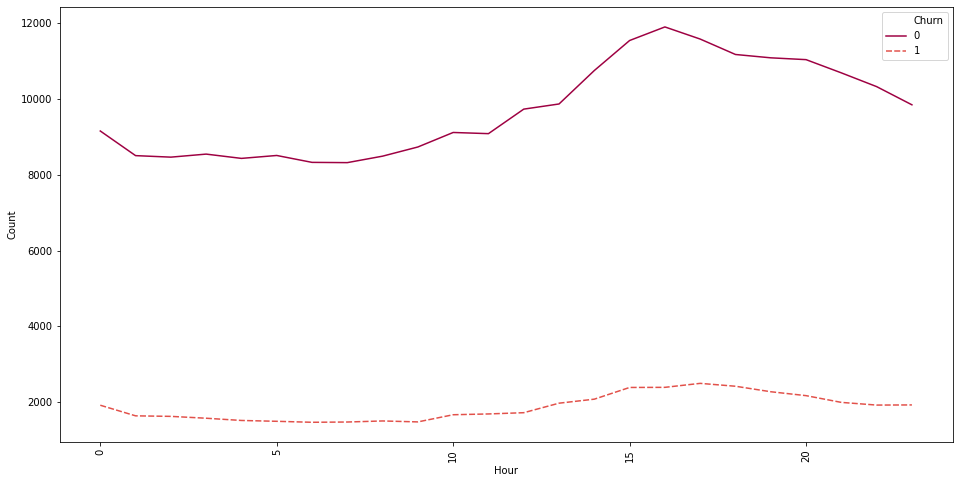

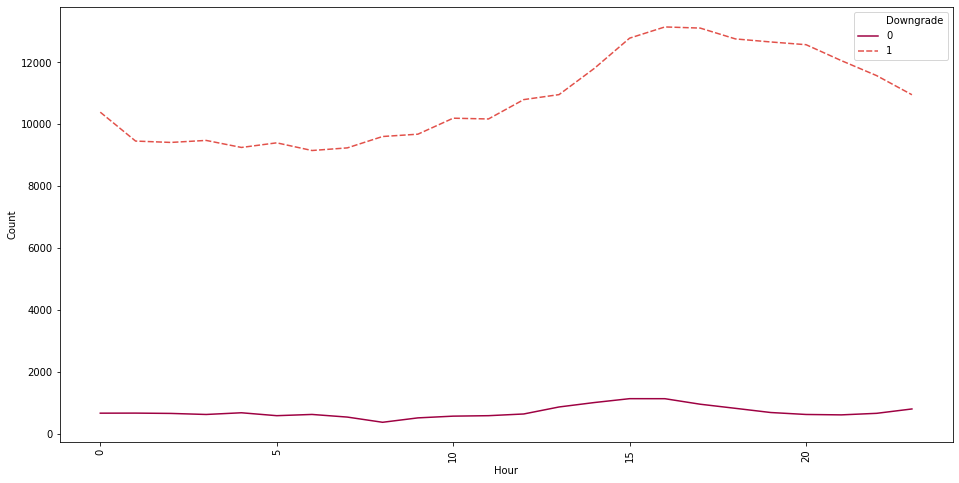

In [33]:
for i in ['churn']:
    events_per_hour = df_clean.groupby('hour',i).count().sort('hour',i)

    plot_line_chart(events_per_hour, 'hour', 'count', i, line_style=i, color=colors[:2])

## Feature Engineering

Check whether churned users return. If users returned after churn, it would be important to restrict the training data to the data rows prior to the churn event because only the prior behavior should predict a following churn.

In [19]:
df_position = df_clean.withColumn('position', row_number()
                        .over(Window.partitionBy('userId')
                        .orderBy('ts')))

check_cancellation_position = df_position.filter(col('churn')==1) \
                                         .filter(col('page')=='Cancellation Confirmation') \
                                         .groupby('userId') \
                                         .agg({'position':'max'})
check_other_position = df_position.filter(col('churn')==1) \
                                  .filter(col('page')!='Cancellation Confirmation') \
                                  .groupby('userId') \
                                  .agg({'position':'max'})

if check_cancellation_position.join(check_other_position, on='userId',how='inner') \
                                  .withColumn('diff',check_cancellation_position['max(position)']-check_other_position['max(position)']) \
                                  .filter(col('diff')<0).show() == []:
    print('Churn users return.')
else: 
    print('Churn users do not return.')

+------+-------------+-------------+----+
|userId|max(position)|max(position)|diff|
+------+-------------+-------------+----+
+------+-------------+-------------+----+

Churn users do not return.


In [36]:
df_clean.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- registration_datetime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- registration_date: string (nullable = true)
 |-- weekday: string (nullable = true)
 |-- registration_weekday: string (nullable = true)
 |-- year: string (nullable = true)
 

The following features per user are extracted in order to predict the label `churn`:

| Feature | Description | Calculation | 
| :--     | :--     | :--        |
| gender     | gender  | unique per user        |     
| browser_*     | browser  | % share over events per user        |        
| device_*     | device / operating system  | % share over events per user        |        
| page_*     | page  | % share over events per user        |        
| level_*     | level  | % share over events per user       |
| weekday_*     | weekday  | % share over events per user        |        
| day_half_*     | half of the day  | % share over events per user        |        
| sessions     | unique sessions per user  | distinct count per user       |        
| items     | total items per user  | count per user        |        
| songs     | total songs per user  | % share over total items per user        |        
| unique_songs     | unique songs per user  | % share over total songs per user        |        
| unique_artists     | unique artists per user | distinct count per user        |        
| session_length     | average length per session per user  | average over sessions per user        |        
| song_length    | average length per song per user  | average over song events per user        |        
| days_since_registration     | days since registration  | unique per user        |        

`_*` indicates originally categorical features (n levels) that are transformed into multiple columns, one per category of the respective feature.

### Categorical Features

2-level categorical features transformed to binary integer

In [19]:
def encode_2_level(df, col_name, categories):
    '''
    '''
    df_encoded = df.select('userId', col_name) \
                   .dropDuplicates() \
                   .replace(categories, ['0', '1'], col_name)
    df_encoded = df_encoded.withColumn(col_name, df_encoded[col_name].cast(IntegerType()))
    
    return df_encoded

n-level categorical features transformed to single columns per category

In [20]:
def fan_out_categories(df, col_name):
    '''
    '''
    categories = list(df.select(col_name).dropDuplicates().toPandas()[col_name])
    events_per_user = df.groupby('userId').count().withColumnRenamed('count', 'total_events')
    categories_df_list = []

    for c in categories:
        df_c = df.filter(col(col_name) == c) \
                       .groupBy('userId') \
                       .agg({col_name: 'count'}) \
                       .withColumnRenamed('count({})'.format(col_name),'count_events')
        df_c = events_per_user.join(df_c, on='userId', how='inner') \
                              .withColumn('{}_{}'.format(col_name,c.lower().replace(" ", "_")), df_c['count_events']/events_per_user['total_events']) \
                              .drop('count_events','total_events')
        categories_df_list.append(df_c)

    df_fan_out = events_per_user.select('userId')

    for c in categories_df_list:
        df_fan_out = df_fan_out.join(c, on='userId', how='full')
        
    return df_fan_out

In [21]:
def calculate_categorical_features():
    '''
    '''
    # Feature GENDER
    df_gender = encode_2_level(df_clean, 'gender', ['M','F'])
    gender = df_gender.select('userId','gender').dropDuplicates()
    gender.persist()

    # Feature BROWSER
    browser = fan_out_categories(df_clean, 'browser')
    browser.persist()

    # Feature DEVICE
    device = fan_out_categories(df_clean, 'device_os')
    device.persist()

    # Feature PAGE
    # pages 'Cancellation Confirmation' & 'Cancel' must be filtered out to avoid perfect overfitting,
    # since this is the definition of churn
    page = fan_out_categories(df_clean.filter(col('page')!='Cancellation Confirmation')
                                      .filter(col('page')!='Cancel'), 'page')
    page.persist()

    # Feature LEVEL
    level = fan_out_categories(df_clean, 'level')
    level.persist()

    # Feature WEEKDAY
    weekday = fan_out_categories(df_clean, 'weekday')
    weekday.persist()

    # Feature DAY_HALF
    day_half = fan_out_categories(df_clean, 'day_half')
    day_half.persist()
    
    categorical_features = gender.join(browser,on='userId',how='inner') \
                                 .join(device,on='userId',how='inner') \
                                 .join(page,on='userId',how='inner') \
                                 .join(level,on='userId',how='inner') \
                                 .join(weekday,on='userId',how='inner') \
                                 .join(day_half,on='userId',how='inner')
    
    return categorical_features

In [22]:
categorical_features = calculate_categorical_features()

In [204]:
categorical_features.head()

Row(userId='100010', gender=1, state_vec=SparseVector(58, {11: 1.0}), state='CT', browser_internet_explorer=None, browser_firefox=None, browser_safari=1.0, browser_chrome=None, device_os_ipad=None, device_os_x11=None, device_os_iphone=1.0, device_os_macintosh=None, device_os_windows=None, page_submit_downgrade=None, page_thumbs_down=0.013123359580052493, page_home=0.028871391076115485, page_downgrade=None, page_roll_advert=0.13648293963254593, page_logout=0.013123359580052493, page_save_settings=None, page_about=0.0026246719160104987, page_settings=None, page_add_to_playlist=0.01837270341207349, page_add_friend=0.010498687664041995, page_nextsong=0.7217847769028871, page_thumbs_up=0.04461942257217848, page_help=0.005249343832020997, page_upgrade=0.005249343832020997, page_error=None, page_submit_upgrade=None, level_free=1.0, level_paid=None, weekday_3=None, weekday_0=0.31758530183727035, weekday_5=0.15748031496062992, weekday_6=None, weekday_1=0.14435695538057744, weekday_4=0.293963254

### Numerical Features

In [23]:
def calculate_numerical_features():
    '''
    '''
    # Feature SESSIONS
    sessions = df_clean.select('userId','sessionId') \
                       .dropDuplicates() \
                       .groupby('userId') \
                       .count() \
                       .withColumnRenamed('count','sessions')
    sessions.persist()

    # Feature ITEMS
    items = df_clean.groupby('userId') \
                    .count() \
                    .withColumnRenamed('count','items')
    items.persist()

    # Feature SONGS
    total_songs = df_clean.filter(col('page')=='NextSong') \
                          .groupby('userId') \
                          .count() \
                          .withColumnRenamed('count','total_songs')

    songs = items.join(total_songs, on='userId',how='inner') \
                 .withColumn('songs',total_songs['total_songs']/items['items']) \
                 .drop('items')
    songs.persist()

    # Feature UNIQUE_SONGS
    total_unique_songs = df_clean.filter(col('page')=='NextSong') \
                                 .select('userId','song') \
                                 .dropDuplicates() \
                                 .groupby('userId') \
                                 .count() \
                                 .withColumnRenamed('count','total_unique_songs')

    unique_songs = songs.join(total_unique_songs, on='userId',how='inner') \
                        .withColumn('unique_songs',total_unique_songs['total_unique_songs']/songs['total_songs']) \
                        .drop('songs')
    unique_songs.persist()

    # Feature UNIQUE_ARTISTS
    unique_artists = df_clean.filter(col('page')=='NextSong') \
                             .select('userId','artist') \
                             .dropDuplicates() \
                             .groupby('userId') \
                             .count() \
                             .withColumnRenamed('count','unique_artists')
    unique_artists.persist()

    # Feature SESSION_LENGTH
    session_length = df_clean.filter(col('page')=='NextSong') \
                             .groupby('userId','sessionId') \
                             .agg({'length':'sum'}) \
                             .groupby('userId') \
                             .agg({'sum(length)':'avg'}) \
                             .withColumnRenamed('avg(sum(length))','session_length')
    session_length.persist()

    # Feature SONG_LENGTH
    song_length = df_clean.filter(col('page')=='NextSong') \
                          .groupby('userId','song') \
                          .agg({'length':'sum'}) \
                          .groupby('userId') \
                          .agg({'sum(length)':'avg'}) \
                          .withColumnRenamed('avg(sum(length))','song_length')
    song_length.persist()

    # Feature DAYS_SINCE_REGISTRATION
    days_since_registration = df_clean.groupby('userId') \
                                      .agg({'days_since_registration':'max'}) \
                                      .withColumnRenamed('max(days_since_registration)','days_since_registration')
    days_since_registration.persist()
    
    numerical_features = sessions.join(items,on='userId',how='inner') \
                                 .join(songs,on='userId',how='inner') \
                                 .join(unique_songs,on='userId',how='inner') \
                                 .join(unique_artists,on='userId',how='inner') \
                                 .join(session_length,on='userId',how='inner') \
                                 .join(song_length,on='userId',how='inner') \
                                 .join(days_since_registration,on='userId',how='inner') \
                                 .drop('total_unique_songs','total_songs')
    
    return numerical_features

In [24]:
numerical_features = calculate_numerical_features()

In [207]:
numerical_features.head()

Row(userId='100010', sessions=7, items=381, songs=0.7217847769028871, unique_songs=0.9781818181818182, unique_artists=252, session_length=9562.985335714286, song_length=248.85091951672862, days_since_registration=55)

### Labels

In [25]:
labels = df_clean.select('userId','churn').dropDuplicates()

In [36]:
labels.head()

Row(userId='100010', churn=0, downgrade=0)

### Merge Features & Labels

In [26]:
modeling_data = labels.join(numerical_features, on='userId', how='inner') \
                      .join(categorical_features, on='userId', how='inner') \
                      .drop('userId')

In [27]:
modeling_data.write.mode('overwrite').save('modeling_data.json',format='json',header=True)

In [28]:
modeling_data = spark.read.json('modeling_data.json')

In [29]:
modeling_data.head()

Row(browser_chrome=None, browser_firefox=None, browser_internet_explorer=1.0, browser_safari=None, churn=0, day_half_1=0.5020080321285141, day_half_2=0.4979919678714859, days_since_registration=173, device_os_ipad=None, device_os_iphone=None, device_os_macintosh=None, device_os_windows=1.0, device_os_x11=None, downgrade=1, gender=1, items=1245, level_free=0.5550200803212851, level_paid=0.44497991967871486, page_about=None, page_add_friend=0.015261044176706828, page_add_to_playlist=0.018473895582329317, page_downgrade=0.008032128514056224, page_error=0.001606425702811245, page_help=0.004819277108433735, page_home=0.05301204819277108, page_logout=0.015261044176706828, page_nextsong=0.7566265060240964, page_roll_advert=0.06907630522088354, page_save_settings=0.001606425702811245, page_settings=0.008835341365461847, page_submit_downgrade=0.001606425702811245, page_submit_upgrade=0.0024096385542168677, page_thumbs_down=0.008835341365461847, page_thumbs_up=0.028112449799196786, page_upgrade=

#### Fill missing values:

In [30]:
modeling_data = modeling_data.fillna(0)

#### Assemble features in vector:

In [31]:
features = modeling_data.drop('churn').columns

assembler = VectorAssembler(inputCols=features, outputCol='features_vec')
modeling_data = assembler.transform(modeling_data)

In [32]:
modeling_data.head()

Row(browser_chrome=0.0, browser_firefox=0.0, browser_internet_explorer=1.0, browser_safari=0.0, churn=0, day_half_1=0.5020080321285141, day_half_2=0.4979919678714859, days_since_registration=173, device_os_ipad=0.0, device_os_iphone=0.0, device_os_macintosh=0.0, device_os_windows=1.0, device_os_x11=0.0, downgrade=1, gender=1, items=1245, level_free=0.5550200803212851, level_paid=0.44497991967871486, page_about=0.0, page_add_friend=0.015261044176706828, page_add_to_playlist=0.018473895582329317, page_downgrade=0.008032128514056224, page_error=0.001606425702811245, page_help=0.004819277108433735, page_home=0.05301204819277108, page_logout=0.015261044176706828, page_nextsong=0.7566265060240964, page_roll_advert=0.06907630522088354, page_save_settings=0.001606425702811245, page_settings=0.008835341365461847, page_submit_downgrade=0.001606425702811245, page_submit_upgrade=0.0024096385542168677, page_thumbs_down=0.008835341365461847, page_thumbs_up=0.028112449799196786, page_upgrade=0.006425

## Modeling

#### Instantiate classifiers:

In [94]:
lr = LogisticRegression(featuresCol='features_vector_scaled', labelCol='churn')
rf = RandomForestClassifier(featuresCol='features_vector_scaled', labelCol='churn')
gbt = GBTClassifier(featuresCol='features_vector_scaled', labelCol='churn')

#### Instantiate feature scaler:

In [34]:
scaler = MinMaxScaler(inputCol='features_vec', outputCol='features_vector_scaled')

#### Prepare training & prediction:

In [35]:
def train_model(clf, train, scaler, file_name):
    '''
    '''
    # set up pipeline with scaler & classifier
    pipeline = Pipeline(stages=[scaler, clf])
    
    # train
    t0 = time()
    model = pipeline.fit(train)
    print('Training time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    # save model
    model.stages[-1].write().overwrite().save(file_name)
    
    return model
    
def test_model(model, test):
    '''
    '''
    # predict
    t0 = time()
    pred = model.transform(test)
    print('Prediction time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    return pred

#### Prepare evaluation:

In [36]:
def evaluate_model(pred_df, pred_col, true_col, clf_name):
    '''
    '''
    evaluation_dict = {}
    
    # initialize
    evaluator = MulticlassClassificationEvaluator(labelCol=true_col)
    
    # calculate metrics
    accuracy = evaluator.evaluate(pred_df.select(true_col,pred_col), {evaluator.metricName: 'accuracy'})
    f1 = evaluator.evaluate(pred_df.select(true_col,pred_col), {evaluator.metricName: 'f1'})
    
    evaluation_dict['accuracy'] = accuracy
    evaluation_dict['f1'] = f1
    evaluation_dict['clf'] = clf_name

    print('Accuracy: {}%'.format('{:.0f}'.format(accuracy*100)))
    print('F1 Score: {}%'.format('{:.0f}'.format(f1*100)))
    
    return evaluation_dict

In [37]:
cmap = plt.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0, 1, 8)]

def compare_evaluated_models(evaluation_list):
    '''
    '''
    # merge evaluations
    evaluations = {}
    for k in evaluation_list[0].keys():
      evaluations[k] = tuple(evaluations[k] for evaluations in evaluation_list)

    # transform to pandas dataframe
    evaluations = pd.DataFrame.from_dict(evaluations)

    # figure settings
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8), sharey=True)

    ax1 = sns.barplot(ax=ax1, x=evaluations['clf'], y=evaluations['f1'], palette=colors)
    ax1.set(xlabel='Classifier'.replace('_',' ').title(), ylabel='f1'.replace('_',' ').title())
    for index, row in evaluations.iterrows():
        ax1.text(row.name, row.f1+0.01, '{:.0f}'.format(row.f1*100)+'%', color='black', ha='center')

    ax2 = sns.barplot(ax=ax2, x=evaluations['clf'], y=evaluations['accuracy'],  palette=colors)
    ax2.set(xlabel='Classifier'.replace('_',' ').title(), ylabel='accuracy'.replace('_',' ').title())
    for index, row in evaluations.iterrows():
        ax2.text(row.name, row.accuracy+0.01, '{:.0f}'.format(row.accuracy*100)+'%', color='black', ha='center')

    plt.show()   

#### Split Train & Test Sets:

In [93]:
# split data into train and test set
train, test = modeling_data.randomSplit([0.8, 0.2], seed=31)

### Logistic Regression

In [95]:
lr_model = train_model(lr, train, scaler, 'lr.model')

Training time: 4.51s


### Random Forest Classifier

In [96]:
rf_model = train_model(rf, train, scaler, 'rf.model')

Training time: 1.92s


### Gradient-Boosted Tree Classifier

In [97]:
gbt_model = train_model(gbt, train, scaler, 'gbt.model')

Training time: 12.15s


### Model Comparison

Prediction time: 0.11s
Accuracy: 88%
F1 Score: 88%


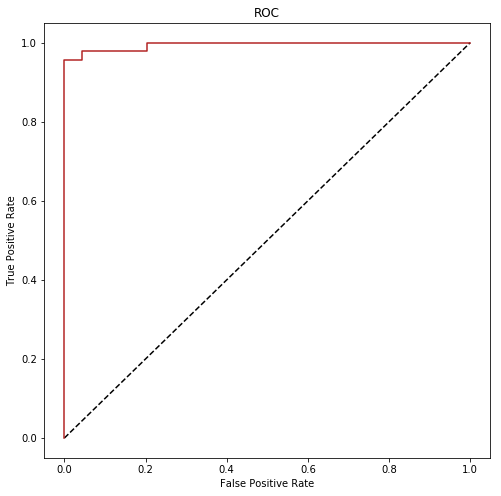

In [98]:
lr_pred = test_model(lr_model, test)
lr_evaluation = evaluate_model(lr_pred,'prediction','churn','Logistic Regression')

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_model.stages[-1].summary.roc.select('FPR').collect(),
         lr_model.stages[-1].summary.roc.select('TPR').collect(), color ='firebrick')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [99]:
rf_pred = test_model(rf_model, test)
rf_evaluation = evaluate_model(rf_pred,'prediction','churn','Random Forest')

Prediction time: 0.04s
Accuracy: 84%
F1 Score: 83%


In [100]:
rf_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0073, 1: 0.0106, 4: 0.0204, 5: 0.0236, 6: 0.2039, 9: 0.0065, 10: 0.0015, 11: 0.0016, 12: 0.0012, 13: 0.0146, 14: 0.0181, 15: 0.018, 16: 0.0239, 17: 0.039, 18: 0.026, 19: 0.0201, 20: 0.0128, 21: 0.0173, 22: 0.0269, 23: 0.0251, 24: 0.0305, 25: 0.0398, 26: 0.0138, 27: 0.0106, 28: 0.0046, 29: 0.0138, 30: 0.0695, 31: 0.0194, 32: 0.0053, 33: 0.0236, 34: 0.0118, 35: 0.019, 36: 0.0252, 37: 0.0222, 38: 0.0235, 39: 0.0148, 40: 0.015, 41: 0.0223, 42: 0.0104, 43: 0.0479, 44: 0.0093, 45: 0.0292})

In [101]:
gbt_pred = test_model(gbt_model, test)
gbt_evaluation = evaluate_model(gbt_pred,'prediction','churn','Gradient-Boosted Tree')

Prediction time: 0.07s
Accuracy: 74%
F1 Score: 78%


In [102]:
gbt_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0001, 1: 0.0, 2: 0.0069, 3: 0.0, 4: 0.0744, 5: 0.0396, 6: 0.1608, 12: 0.0081, 13: 0.0207, 14: 0.0054, 16: 0.056, 17: 0.0124, 18: 0.0555, 19: 0.0424, 20: 0.0168, 21: 0.0005, 22: 0.0172, 23: 0.0272, 24: 0.0065, 25: 0.0222, 26: 0.009, 27: 0.0132, 28: 0.0035, 29: 0.0076, 30: 0.0985, 31: 0.0326, 32: 0.0095, 33: 0.0168, 35: 0.0069, 36: 0.044, 37: 0.0094, 38: 0.0032, 39: 0.0104, 40: 0.0274, 41: 0.0107, 42: 0.0436, 43: 0.0216, 44: 0.0474, 45: 0.0121})

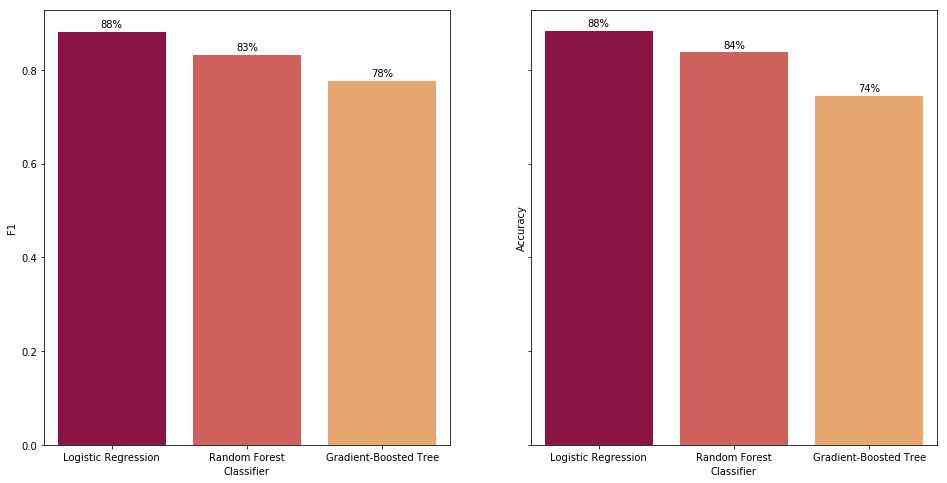

In [103]:
compare_evaluated_models([lr_evaluation, rf_evaluation, gbt_evaluation])

**Conclusion:** With default parameters, the Logistic Regression appears to be the best performing model in terms of F1 score (88%) & accuracy (88%).

### Hyperparameter Tuning

#### Prepare cross-validation:

In [48]:
def tune_hyperparameters(clf, parameters, label_col, train, scaler, folds=3):
    '''
    '''
    # set up pipeline with scaler & classifier
    pipeline = Pipeline(stages=[scaler, clf])
    
    # set up cross-validation for hyperparameters
    crossval = CrossValidator(estimator=pipeline, 
                              estimatorParamMaps=parameters,
                              evaluator=MulticlassClassificationEvaluator(labelCol=label_col),
                              numFolds=folds)
    
    # train
    t0 = time()
    cv_model = crossval.fit(train)
    print('Training time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    return cv_model

def test_best_model(cv_model, test, file_name):
    '''
    '''
    best = cv_model.bestModel
    
    # predict
    t0 = time()
    best_pred = best.transform(test)
    print('Prediction time: {}s'.format('{:.2f}'.format(time() - t0)))
    
    # save model
    best.write().overwrite().save(file_name)
    
    return best, best_pred

### Logistic Regression - CV

#### Calculation of balancing ratio for label weights in logistic regression:

In [104]:
count_negatives = modeling_data.filter(col('churn')==0).count()
count_dataset = modeling_data.count()
balancing_ratio= count_negatives/count_dataset
print('Balancing Ratio = {}'.format(balancing_ratio))

Balancing Ratio = 0.7688888888888888


In [105]:
train = train.withColumn('label_weights', when(train.churn == 1, balancing_ratio).otherwise(1-balancing_ratio))
train.select('churn','label_weights').dropDuplicates().show()

+-----+-------------------+
|churn|      label_weights|
+-----+-------------------+
|    1| 0.7688888888888888|
|    0|0.23111111111111116|
+-----+-------------------+



#### Re-Instantiate classifier using weightCol:

In [108]:
lr = LogisticRegression(featuresCol='features_vector_scaled', labelCol='churn', weightCol='label_weights')

In [109]:
lr_paramGrid = ParamGridBuilder().addGrid(lr.elasticNetParam,[0.0, 0.5, 1.0]) \
                                 .addGrid(lr.regParam, [0.0, 0.05, 0.1]) \
                                 .addGrid(lr.maxIter, [10, 50, 100]) \
                                 .build()

lr_cv_model = tune_hyperparameters(lr, lr_paramGrid, 'churn', train, scaler)

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/opt/spark-2.4.3-bin-hadoop2.7/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'


Training time: 288.71s


### Random Forest Classifier - CV

In [110]:
rf_paramGrid = ParamGridBuilder().addGrid(rf.numTrees,[10, 50, 100]) \
                                 .addGrid(rf.maxDepth, [3, 5, 10, 15]) \
                                 .addGrid(rf.maxBins, [10, 32, 50]) \
                                 .build()

rf_cv_model = tune_hyperparameters(rf, rf_paramGrid, 'churn', train, scaler)

Training time: 182.75s


### Gradient-Boosted Tree Classifier - CV

In [111]:
gbt_paramGrid = ParamGridBuilder().addGrid(gbt.maxDepth,[3, 5, 10, 15]) \
                                  .addGrid(gbt.maxBins,[10, 32, 50]) \
                                  .build()
                                  
gbt_cv_model = tune_hyperparameters(gbt, gbt_paramGrid, 'churn', train, scaler)

Training time: 488.61s


### Model Comparison - CV

Prediction time: 0.18s
{'regParam': 0.0, 'MaxIter': 100, 'elasticNetParam': 0.0}
Accuracy: 86%
F1 Score: 87%


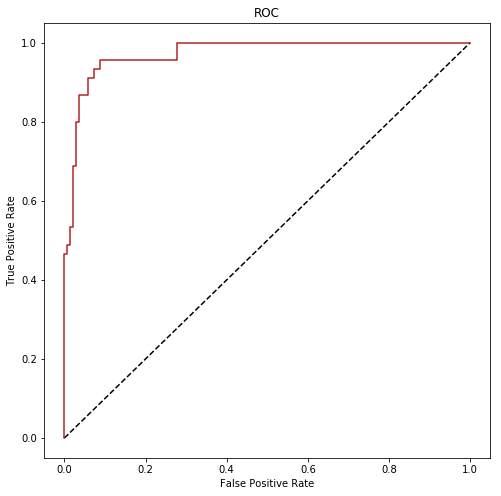

In [112]:
lr_best_model, lr_best_pred = test_best_model(lr_cv_model, test, 'lr_cv.model')
lr_best_parameters = {'regParam':lr_best_model.stages[-1]._java_obj.getRegParam(),
                      'MaxIter':lr_best_model.stages[-1]._java_obj.getMaxIter(),
                      'elasticNetParam':lr_best_model.stages[-1]._java_obj.getElasticNetParam()}
print(lr_best_parameters)
lr_best_evaluation = evaluate_model(lr_best_pred,'prediction','churn','Linear Regression')

plt.figure(figsize=(8,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_best_model.stages[-1].summary.roc.select('FPR').collect(),
         lr_best_model.stages[-1].summary.roc.select('TPR').collect(), color ='firebrick')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.show()

In [113]:
rf_best_model, rf_best_pred = test_best_model(rf_cv_model, test, 'rf_cv.model')
rf_best_parameters = {'numTrees':rf_best_model.stages[-1]._java_obj.getNumTrees(),
                      'maxDepth':rf_best_model.stages[-1]._java_obj.getMaxDepth(),
                      'maxBins':rf_best_model.stages[-1]._java_obj.getMaxBins()}
print(rf_best_parameters)
rf_best_evaluation = evaluate_model(rf_best_pred,'prediction','churn','Random Forest')

Prediction time: 0.04s
{'numTrees': 100, 'maxDepth': 10, 'maxBins': 32}
Accuracy: 91%
F1 Score: 90%


In [114]:
rf_best_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0069, 1: 0.0067, 2: 0.0009, 3: 0.0025, 4: 0.0277, 5: 0.0294, 6: 0.1085, 7: 0.0004, 8: 0.0012, 9: 0.0053, 10: 0.0044, 11: 0.003, 12: 0.0028, 13: 0.0242, 14: 0.014, 15: 0.0122, 16: 0.02, 17: 0.033, 18: 0.03, 19: 0.0227, 20: 0.0169, 21: 0.02, 22: 0.0216, 23: 0.0234, 24: 0.0157, 25: 0.0273, 26: 0.0155, 27: 0.0272, 28: 0.0084, 29: 0.0159, 30: 0.0657, 31: 0.0439, 32: 0.0205, 33: 0.0271, 34: 0.0204, 35: 0.0261, 36: 0.0272, 37: 0.0206, 38: 0.0224, 39: 0.0278, 40: 0.0243, 41: 0.0212, 42: 0.024, 43: 0.0302, 44: 0.0263, 45: 0.0248})

In [115]:
gbt_best_model, gbt_best_pred = test_best_model(gbt_cv_model, test, 'gbt_cv.model')
gbt_best_parameters = {'maxDepth':gbt_best_model.stages[-1]._java_obj.getMaxDepth(),
                       'maxBins':gbt_best_model.stages[-1]._java_obj.getMaxBins()}
print(gbt_best_parameters)
gbt_best_evaluation = evaluate_model(gbt_best_pred,'prediction','churn','Gradient-Boosted Tree')

Prediction time: 0.08s
{'maxDepth': 3, 'maxBins': 50}
Accuracy: 86%
F1 Score: 87%


In [116]:
gbt_best_model.stages[-1].featureImportances

SparseVector(46, {0: 0.0144, 1: 0.0194, 3: 0.0021, 4: 0.0429, 5: 0.1199, 6: 0.1145, 13: 0.0052, 14: 0.0238, 15: 0.0101, 16: 0.0138, 17: 0.0077, 18: 0.033, 20: 0.0102, 21: 0.0151, 22: 0.0399, 23: 0.0047, 24: 0.022, 25: 0.045, 26: 0.0081, 27: 0.0102, 30: 0.1453, 31: 0.0594, 32: 0.0046, 33: 0.0079, 34: 0.0138, 35: 0.0076, 36: 0.0105, 38: 0.0265, 39: 0.0469, 41: 0.0087, 42: 0.0491, 43: 0.0328, 44: 0.0069, 45: 0.0178})

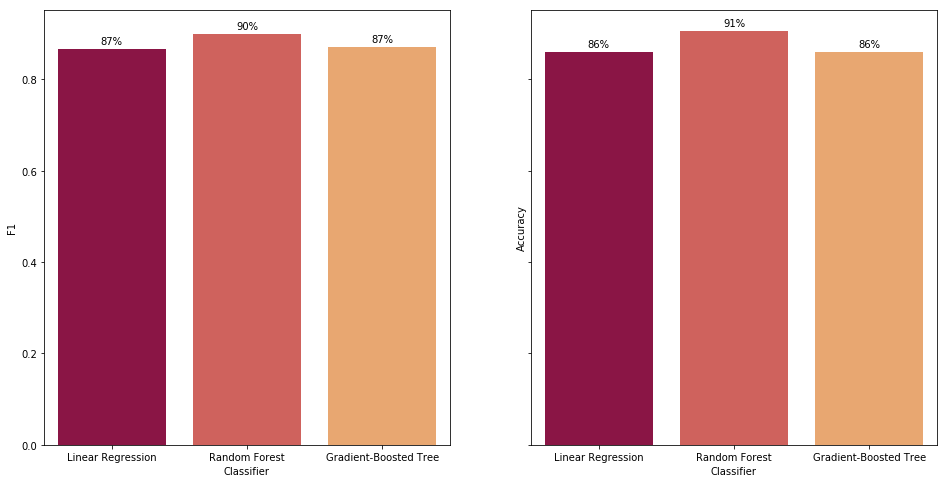

In [117]:
compare_evaluated_models([lr_best_evaluation, rf_best_evaluation, gbt_best_evaluation])

**Conclusion:** After hyperparameter tuning, the Random Forest Classifier appears to be the best performing model in terms of F1 score (90%) & accuracy (91%).